In [1]:
EXPERIMENT = '05-10'
N_SPLITS = 5
SEED = 1
CLIP_UPPER_RATE = 1.5
CLIP_LOWER_RATE = 1.0
Y_THRESHOLD = 200

In [2]:
from collections import defaultdict
import configparser
from functools import partial
from itertools import chain
import json
import logging
import os
import pickle
import re
import sys
import time

SINCE = time.time()

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import StackingRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error as mse, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearnex import patch_sklearn

config = configparser.ConfigParser()
INI_FILEPATH = os.path.join(os.path.expanduser('~'), 'aiquest2021-assesment', 'config.ini')
config.read(INI_FILEPATH)
if config['FOLDER']['SCRIPTS'] not in sys.path:
    sys.path.append(config['FOLDER']['SCRIPTS'])
from logging_util import get_logger, timer
from feature_engineering import make_or_load_features
from text_feature_extraction import make_or_load_vector

In [3]:
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
output_dir = os.path.join(config['FOLDER']['EXPERIMENTS'], EXPERIMENT)
os.makedirs(output_dir)

In [5]:
logger = get_logger(__name__, os.path.join(output_dir, 'log.log'))

# Loading

In [6]:
with timer('Load dataset', logger):
    train = pd.read_csv(os.path.join(config['FOLDER']['INPUT'], 'train.csv'))
    test = pd.read_csv(os.path.join(config['FOLDER']['INPUT'], 'test.csv'))
    sample_submit = pd.read_csv(os.path.join(config['FOLDER']['INPUT'], 'sample_submit.csv'))

# Feature engineering

In [7]:
train_path = os.path.join(config['FOLDER']['FEATURES'], 'train_features.csv')
test_path = os.path.join(config['FOLDER']['FEATURES'], 'test_features.csv')

In [8]:
X, X_test = make_or_load_features(train, test, train_path, test_path, logger)

In [9]:
X

,id,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,...,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_review_year,last_review_month
0,0,6,2.0,0,1.0,4.0,0,0,1,1,...,0,0,0,1,2016.0,7.0,2016.0,7.0,2016.0,7.0
1,1,2,1.0,0,1.0,1.0,1,1,1,1,...,1,1,0,0,2016.0,9.0,2015.0,12.0,2017.0,3.0
2,2,2,2.0,0,1.0,1.0,1,2,1,1,...,2,2,1,0,2016.0,6.0,2016.0,5.0,2017.0,8.0
3,3,2,1.0,0,1.0,1.0,1,3,1,1,...,0,3,0,1,2014.0,3.0,2012.0,6.0,2017.0,9.0
4,4,2,1.0,0,1.0,1.0,1,2,1,1,...,2,4,0,0,2015.0,8.0,2015.0,3.0,2017.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55578,55578,4,1.5,0,1.0,1.0,1,2,1,1,...,2,95,0,0,2013.0,2.0,2013.0,1.0,2017.0,9.0
55579,55579,2,1.0,0,1.0,1.0,2,4,0,1,...,3,181,0,0,2015.0,11.0,2015.0,1.0,2016.0,10.0
55580,55580,2,1.0,0,1.0,1.0,0,3,1,1,...,0,33,0,0,2016.0,3.0,2016.0,2.0,2017.0,4.0
55581,55581,1,1.5,0,1.0,1.0,2,0,1,1,...,0,251,0,0,2016.0,10.0,2016.0,4.0,2017.0,4.0


In [10]:
X_test

,id,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,...,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_review_year,last_review_month
0,0,6,2.0,0,2.0,2.0,1,5,1,1,...,4,88,0,0,2017.0,1.0,2016.0,8.0,2017.0,9.0
1,1,3,1.0,0,1.0,1.0,2,0,1,1,...,0,16,0,0,2016.0,8.0,2014.0,9.0,2017.0,5.0
2,2,2,1.0,0,0.0,1.0,0,2,0,1,...,2,90,0,0,NaN,NaN,2012.0,10.0,NaN,NaN
3,3,4,1.0,0,1.0,2.0,1,2,0,1,...,2,44,0,0,NaN,NaN,2013.0,1.0,NaN,NaN
4,4,3,1.5,0,1.0,2.0,1,0,1,1,...,0,129,0,0,2015.0,8.0,2014.0,12.0,2016.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18523,18523,4,1.0,0,2.0,2.0,1,2,1,1,...,2,109,0,0,NaN,NaN,2009.0,11.0,NaN,NaN
18524,18524,2,1.0,0,2.0,1.0,0,4,0,1,...,3,22,0,1,2017.0,1.0,2017.0,1.0,2017.0,4.0
18525,18525,5,1.5,0,2.0,2.0,0,4,1,1,...,3,181,0,0,NaN,NaN,2014.0,9.0,NaN,NaN
18526,18526,2,1.0,0,1.0,2.0,1,2,1,1,...,2,158,0,0,2016.0,4.0,2014.0,3.0,2017.0,5.0


In [11]:
X.columns = [re.sub(r"[:;/']", '', c) for c in X.columns]
X_test.columns = [re.sub(r"[:;/']", '', c) for c in X.columns]

In [12]:
# Clustering
area_features = ['latitude', 'longitude']

# Onehot encoding
categorical_features = ['cancellation_policy', 'bed_type', 'city', 'neighbourhood', 'property_type',
                        'room_type', 'zipcode5', 'zipcode_1st_digit']

# They do not need to be encoded
int_flag_features = ['cleaning_fee', 'host_has_profile_pic', 'host_identity_verified',
                     'instant_bookable', 'has_thumbnail', 'zipcode_imputed']

# Already one-hot style
amenity_onehot_features = [c for c in X.columns if c.startswith('has_') and c.endswith('_amenity')]

discrete_features = categorical_features + int_flag_features + amenity_onehot_features

# Scaling, transformation
continuous_features = [
    c for c in X.columns
    if c not in discrete_features + area_features + ['id', 'y']
]

In [13]:
%%time
# Reduce dimension & whitening
## training
decomposer = PCA(n_components=0.8, random_state=SEED, whiten=True).fit(X[amenity_onehot_features])
X_amenity_components = decomposer.transform(X[amenity_onehot_features])
amenity_components_columns = [f'amenity_x{i + 1}' for i in range(decomposer.n_components_)]
X_amenity_components = pd.DataFrame(data=X_amenity_components,
                                    columns=amenity_components_columns)
X = pd.concat([X, X_amenity_components], axis=1)
# X.drop(columns=amenity_onehot_features, inplace=True)
X_test_amenity_components = decomposer.transform(X_test[amenity_onehot_features])
X_test_amenity_components = pd.DataFrame(data=X_test_amenity_components,
                                         columns=amenity_components_columns)
X_test = pd.concat([X_test, X_test_amenity_components], axis=1)
# X_test.drop(columns=amenity_onehot_features, inplace=True)

Wall time: 542 ms


In [14]:
f = lambda s1, s2: ' '.join([s1, s2])
train['name+description'] = np.vectorize(f)(train['name'], train['description'])
test['name+description'] = np.vectorize(f)(test['name'], test['description'])

In [15]:
%%time
vec_train, vec_test = make_or_load_vector(train=train,
                                          test=test,
                                          feature_dir=config['FOLDER']['FEATURES'],
                                          logger=logger,
                                          text_column='name+description',
                                          embedder='lda_count',
                                          overwrite=True,
                                          random_state=85)

Wall time: 4min 35s


In [16]:
%%time
vec_columns = vec_train.columns.tolist()

Wall time: 0 ns


In [17]:
%%time
X = pd.concat([X, vec_train], axis=1)
X_test = pd.concat([X_test, vec_test], axis=1)
X.shape, X_test.shape

Wall time: 72.5 ms


((55583, 285), (18528, 285))

In [18]:
passthrough_features = amenity_onehot_features \
                     + amenity_components_columns \
                     + int_flag_features \
                     + area_features \
                     + vec_columns

In [19]:
def get_classifier(continuous_features, discrete_features, passthrough_features, random_state):
    continuous_preprocessor = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]
    )
    categorical_preprocessor = OneHotEncoder(handle_unknown='ignore')
    preprocessor = ColumnTransformer(
        transformers=[
            ('categorical', categorical_preprocessor, continuous_features),
            ('continuous', continuous_preprocessor, discrete_features),
            ('others', 'passthrough', passthrough_features)
        ]
    )
    return Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(random_state=random_state,
                                              max_iter=2000,
                                              n_jobs=-1,
                                              class_weight='balanced'))
        ]
    )

# Cross validation

## Preparation

In [20]:
y_min, y_max = train['y'].min(), train['y'].max()  # clipping に必要

In [21]:
# ターゲットは対数変換する
y = train.set_index('id').loc[X['id']]['y']
y_log = np.log(y)
y_log

id
0        4.927254
1        3.737670
2        4.174387
3        5.111988
4        5.105945
           ...   
55578    5.828946
55579    3.401197
55580    4.605170
55581    3.637586
55582    3.912023
Name: y, Length: 55583, dtype: float64

In [22]:
# Stratified K-fold 用
y_labels = pd.cut(y_log, bins=3, labels=range(3))
y_labels

id
0        1
1        1
2        1
3        2
4        2
        ..
55578    2
55579    1
55580    1
55581    1
55582    1
Name: y, Length: 55583, dtype: category
Categories (3, int64): [0 < 1 < 2]

In [23]:
y_threshold = np.log(Y_THRESHOLD)
y_threshold

5.298317366548036

In [24]:
id_test = X_test['id'].values
id_test

array([    0,     1,     2, ..., 18525, 18526, 18527], dtype=int64)

In [25]:
train.set_index('id', inplace=True)

## Training models

In [26]:
splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
for i, (train_idx, vaild_idx) in enumerate(splitter.split(X=X, y=y_labels)):
    num_fold = i + 1
    logger.debug('Start fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

    # 訓練データと検証データに分割
    id_train = X.iloc[train_idx]['id'].values
    X_train = X.iloc[train_idx].drop(columns=['id'])
    y_train = y_log[train_idx].values
    id_valid = X.iloc[vaild_idx]['id'].values
    X_valid = X.iloc[vaild_idx].drop(columns=['id'])
    y_valid = y_log[vaild_idx].values
    
    # モデルの訓練
    ## 分類モデルの訓練
    with timer('Training: classifier', logger):
        y_train_clf = 1 * (y_train > y_threshold)
        y_valid_clf = 1 * (y_valid > y_threshold)
        classifier = get_classifier(continuous_features=continuous_features,
                                    discrete_features=discrete_features,
                                    passthrough_features=passthrough_features,
                                    random_state=SEED)
        classifier.fit(X_train, y_train_clf)
    ## 分類モデルの評価
    with timer('Evaluate classifier', logger):
        pred_train_clf = classifier.predict(X_train)
        logger.debug('Training f1 score: {:.6f}'.format(f1_score(y_train_clf, pred_train_clf)))
        logger.debug('Training precision: {:.6f}'.format(precision_score(y_train_clf, pred_train_clf)))
        logger.debug('Training recall: {:.6f}'.format(recall_score(y_train_clf, pred_train_clf)))
        pred_valid_clf = classifier.predict(X_valid)
        logger.debug('Validation f1 score: {:.6f}'.format(f1_score(y_valid_clf, pred_valid_clf)))
        logger.debug('Validation precision: {:.6f}'.format(precision_score(y_valid_clf, pred_valid_clf)))
        logger.debug('Validation recall: {:.6f}'.format(recall_score(y_valid_clf, pred_valid_clf)))
    ## `y` 予測モデルの訓練
    with timer('Training regressor', logger):
        class1_mask = y_train > y_threshold
        estimator0 = LGBMRegressor(n_estimators=300,
                                   random_state=SEED,
                                   n_jobs=-1,
                                   learning_rate=0.1,
                                   importance_type='gain')
        estimator0.fit(X_train[~class1_mask], y_train[~class1_mask], categorical_feature=discrete_features)
        estimator1 = StackingRegressor(
            estimators=[
                ('lgbm', LGBMRegressor(n_estimators=300,
                                       random_state=SEED,
                                       n_jobs=-1,
                                       learning_rate=0.1,
                                       importance_type='gain')),
                ('cat', CatBoostRegressor(n_estimators=300,
                                          cat_features=discrete_features,
                                          train_dir=output_dir,
                                          random_state=SEED))
                ],
            cv=5
        )
        estimator1.fit(X_train[class1_mask], y_train[class1_mask])
        
    # 予測結果を保存する
    with timer('Prediction', logger):
        # 訓練データ
        proba_train = classifier.predict_proba(X_train)
        pred_train0 = estimator0.predict(X_train)
        pred_train1 = estimator1.predict(X_train)
        pred_train = pred_train0 * proba_train[:, 0] + pred_train1 * proba_train[:, 1]
        pred_train = pd.DataFrame(data=pred_train, columns=['pred'])
        pred_train['pred'] = np.exp(pred_train['pred'])
        pred_train['pred'].clip(lower=y_min * CLIP_LOWER_RATE, upper=y_max * CLIP_UPPER_RATE, inplace=True)
        # 検証データ
        proba_valid = classifier.predict_proba(X_valid)
        pred_valid0 = estimator0.predict(X_valid)
        pred_valid1 = estimator1.predict(X_valid)
        pred_valid = pred_valid0 * proba_valid[:, 0] + pred_valid1 * proba_valid[:, 1]
        pred_valid = pd.DataFrame(data=pred_valid, columns=['pred'])
        pred_valid['pred'] = np.exp(pred_valid['pred'])
        pred_valid['pred'].clip(lower=y_min * CLIP_LOWER_RATE, upper=y_max * CLIP_UPPER_RATE, inplace=True)
        # テストデータ
        proba_test = classifier.predict_proba(X_test.drop(columns=['id']))
        pred_test0 = estimator0.predict(X_test.drop(columns=['id']))
        pred_test1 = estimator1.predict(X_test.drop(columns=['id']))
        pred_test = pred_test0 * proba_test[:, 0] + pred_test1 * proba_test[:, 1]
        pred_test = pd.DataFrame(data=pred_test, columns=['pred'])
        pred_test['pred'] = np.exp(pred_test['pred'])
        pred_test['pred'].clip(lower=y_min * CLIP_LOWER_RATE, upper=y_max * CLIP_UPPER_RATE, inplace=True)
    with timer('Save prediction', logger):
        ## 訓練データ
        pred_train['id'] = id_train
        pred_train.to_csv(os.path.join(output_dir, f'cv_fold{num_fold}_training.csv'), index=False)
        ## 検証データ
        pred_valid['id'] = id_valid
        pred_valid.to_csv(os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv'), index=False)
        ## テストデータ
        pred_test['id'] = id_test
        pred_test.to_csv(os.path.join(output_dir, f'cv_fold{num_fold}_test.csv'), index=False)
    ## モデルの保存
    with timer('Save model', logger):
        filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.pkl')
        with open(filepath_fold_model, 'wb') as f:
            pickle.dump({
                'class0': estimator0,
                'class1': estimator1,
                'classifier': classifier
            }, f)
    logger.debug('Complete fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Learning rate set to 0.142431
0:	learn: 0.4490804	total: 192ms	remaining: 57.4s
1:	learn: 0.4360362	total: 239ms	remaining: 35.7s
2:	learn: 0.4250694	total: 281ms	remaining: 27.8s
3:	learn: 0.4151632	total: 320ms	remaining: 23.7s
4:	learn: 0.4074854	total: 367ms	remaining: 21.6s
5:	learn: 0.4008170	total: 427ms	remaining: 20.9s
6:	learn: 0.3967223	total: 472ms	remaining: 19.8s
7:	learn: 0.3927106	total: 511ms	remaining: 18.7s
8:	learn: 0.3886738	total: 551ms	remaining: 17.8s
9:	learn: 0.3857706	total: 591ms	remaining: 17.1s
10:	learn: 0.3829793	total: 635ms	remaining: 16.7s
11:	learn: 0.3806979	total: 673ms	remaining: 16.1s
12:	learn: 0.3781352	total: 710ms	remaining: 15.7s
13:	learn: 0.3765910	total: 747ms	remaining: 15.3s
14:	learn: 0.3732808	total: 785ms	remaining: 14.9s
15:	learn: 0.3702405	total: 832ms	remaining: 14.8s
16:	learn: 0.3677096	total: 869ms	remaining: 14.5s
17:	learn: 0.3662266	total: 907ms	remaining: 14.2s
18:	learn: 0.3644930	total: 948ms	remaining: 14s
19:	learn: 0.

160:	learn: 0.2836432	total: 6.71s	remaining: 5.79s
161:	learn: 0.2834499	total: 6.74s	remaining: 5.74s
162:	learn: 0.2830883	total: 6.78s	remaining: 5.7s
163:	learn: 0.2826069	total: 6.82s	remaining: 5.65s
164:	learn: 0.2822013	total: 6.85s	remaining: 5.61s
165:	learn: 0.2817608	total: 6.9s	remaining: 5.57s
166:	learn: 0.2812321	total: 6.93s	remaining: 5.52s
167:	learn: 0.2808191	total: 6.97s	remaining: 5.48s
168:	learn: 0.2802550	total: 7.01s	remaining: 5.43s
169:	learn: 0.2798738	total: 7.05s	remaining: 5.39s
170:	learn: 0.2791371	total: 7.09s	remaining: 5.35s
171:	learn: 0.2786606	total: 7.13s	remaining: 5.31s
172:	learn: 0.2785332	total: 7.17s	remaining: 5.26s
173:	learn: 0.2780589	total: 7.21s	remaining: 5.22s
174:	learn: 0.2776775	total: 7.24s	remaining: 5.17s
175:	learn: 0.2773880	total: 7.29s	remaining: 5.13s
176:	learn: 0.2769797	total: 7.32s	remaining: 5.09s
177:	learn: 0.2766008	total: 7.36s	remaining: 5.04s
178:	learn: 0.2759946	total: 7.4s	remaining: 5s
179:	learn: 0.2758

21:	learn: 0.3547610	total: 831ms	remaining: 10.5s
22:	learn: 0.3537344	total: 882ms	remaining: 10.6s
23:	learn: 0.3524655	total: 918ms	remaining: 10.6s
24:	learn: 0.3511527	total: 955ms	remaining: 10.5s
25:	learn: 0.3501467	total: 997ms	remaining: 10.5s
26:	learn: 0.3486761	total: 1.03s	remaining: 10.5s
27:	learn: 0.3470429	total: 1.07s	remaining: 10.4s
28:	learn: 0.3457354	total: 1.11s	remaining: 10.4s
29:	learn: 0.3445901	total: 1.14s	remaining: 10.3s
30:	learn: 0.3439231	total: 1.19s	remaining: 10.3s
31:	learn: 0.3430932	total: 1.22s	remaining: 10.2s
32:	learn: 0.3421044	total: 1.26s	remaining: 10.2s
33:	learn: 0.3416398	total: 1.31s	remaining: 10.2s
34:	learn: 0.3409163	total: 1.34s	remaining: 10.2s
35:	learn: 0.3397327	total: 1.38s	remaining: 10.1s
36:	learn: 0.3387253	total: 1.43s	remaining: 10.1s
37:	learn: 0.3376301	total: 1.46s	remaining: 10.1s
38:	learn: 0.3367984	total: 1.5s	remaining: 10s
39:	learn: 0.3359620	total: 1.53s	remaining: 9.97s
40:	learn: 0.3350255	total: 1.57s	

182:	learn: 0.2621792	total: 7.11s	remaining: 4.54s
183:	learn: 0.2619692	total: 7.14s	remaining: 4.5s
184:	learn: 0.2617771	total: 7.18s	remaining: 4.46s
185:	learn: 0.2613765	total: 7.23s	remaining: 4.43s
186:	learn: 0.2609888	total: 7.26s	remaining: 4.39s
187:	learn: 0.2605124	total: 7.3s	remaining: 4.35s
188:	learn: 0.2604691	total: 7.33s	remaining: 4.31s
189:	learn: 0.2601150	total: 7.37s	remaining: 4.27s
190:	learn: 0.2599970	total: 7.41s	remaining: 4.23s
191:	learn: 0.2599643	total: 7.46s	remaining: 4.19s
192:	learn: 0.2597703	total: 7.49s	remaining: 4.15s
193:	learn: 0.2593015	total: 7.53s	remaining: 4.11s
194:	learn: 0.2591144	total: 7.56s	remaining: 4.07s
195:	learn: 0.2584912	total: 7.61s	remaining: 4.04s
196:	learn: 0.2581075	total: 7.66s	remaining: 4s
197:	learn: 0.2577525	total: 7.7s	remaining: 3.96s
198:	learn: 0.2573884	total: 7.73s	remaining: 3.92s
199:	learn: 0.2570902	total: 7.77s	remaining: 3.88s
200:	learn: 0.2565950	total: 7.8s	remaining: 3.84s
201:	learn: 0.25623

44:	learn: 0.3366324	total: 1.8s	remaining: 10.2s
45:	learn: 0.3356881	total: 1.84s	remaining: 10.1s
46:	learn: 0.3348635	total: 1.87s	remaining: 10.1s
47:	learn: 0.3340689	total: 1.92s	remaining: 10.1s
48:	learn: 0.3333786	total: 1.97s	remaining: 10.1s
49:	learn: 0.3329091	total: 2s	remaining: 10s
50:	learn: 0.3326565	total: 2.05s	remaining: 10s
51:	learn: 0.3321718	total: 2.09s	remaining: 9.95s
52:	learn: 0.3313094	total: 2.13s	remaining: 9.93s
53:	learn: 0.3306524	total: 2.17s	remaining: 9.88s
54:	learn: 0.3297244	total: 2.21s	remaining: 9.82s
55:	learn: 0.3291223	total: 2.24s	remaining: 9.78s
56:	learn: 0.3280348	total: 2.28s	remaining: 9.73s
57:	learn: 0.3274428	total: 2.33s	remaining: 9.71s
58:	learn: 0.3270581	total: 2.36s	remaining: 9.65s
59:	learn: 0.3266816	total: 2.4s	remaining: 9.6s
60:	learn: 0.3260692	total: 2.44s	remaining: 9.56s
61:	learn: 0.3253116	total: 2.48s	remaining: 9.52s
62:	learn: 0.3245658	total: 2.52s	remaining: 9.49s
63:	learn: 0.3244371	total: 2.56s	remaini

206:	learn: 0.2624198	total: 8.3s	remaining: 3.73s
207:	learn: 0.2618517	total: 8.35s	remaining: 3.69s
208:	learn: 0.2615092	total: 8.38s	remaining: 3.65s
209:	learn: 0.2610593	total: 8.44s	remaining: 3.62s
210:	learn: 0.2607036	total: 8.47s	remaining: 3.57s
211:	learn: 0.2603872	total: 8.51s	remaining: 3.53s
212:	learn: 0.2601083	total: 8.55s	remaining: 3.49s
213:	learn: 0.2598911	total: 8.6s	remaining: 3.45s
214:	learn: 0.2592822	total: 8.64s	remaining: 3.42s
215:	learn: 0.2589130	total: 8.68s	remaining: 3.37s
216:	learn: 0.2587204	total: 8.71s	remaining: 3.33s
217:	learn: 0.2584476	total: 8.76s	remaining: 3.3s
218:	learn: 0.2583082	total: 8.81s	remaining: 3.26s
219:	learn: 0.2580994	total: 8.86s	remaining: 3.22s
220:	learn: 0.2578078	total: 8.89s	remaining: 3.18s
221:	learn: 0.2575471	total: 8.93s	remaining: 3.14s
222:	learn: 0.2570923	total: 8.97s	remaining: 3.1s
223:	learn: 0.2565687	total: 9.02s	remaining: 3.06s
224:	learn: 0.2562333	total: 9.06s	remaining: 3.02s
225:	learn: 0.25

70:	learn: 0.3164944	total: 2.75s	remaining: 8.89s
71:	learn: 0.3159553	total: 2.79s	remaining: 8.84s
72:	learn: 0.3150470	total: 2.83s	remaining: 8.79s
73:	learn: 0.3144097	total: 2.87s	remaining: 8.77s
74:	learn: 0.3136214	total: 2.91s	remaining: 8.72s
75:	learn: 0.3131415	total: 2.94s	remaining: 8.68s
76:	learn: 0.3123933	total: 2.98s	remaining: 8.63s
77:	learn: 0.3117599	total: 3.02s	remaining: 8.58s
78:	learn: 0.3111209	total: 3.06s	remaining: 8.55s
79:	learn: 0.3107340	total: 3.09s	remaining: 8.51s
80:	learn: 0.3101490	total: 3.13s	remaining: 8.46s
81:	learn: 0.3092561	total: 3.17s	remaining: 8.43s
82:	learn: 0.3088470	total: 3.21s	remaining: 8.38s
83:	learn: 0.3081106	total: 3.25s	remaining: 8.36s
84:	learn: 0.3073669	total: 3.3s	remaining: 8.35s
85:	learn: 0.3070501	total: 3.34s	remaining: 8.3s
86:	learn: 0.3063519	total: 3.37s	remaining: 8.26s
87:	learn: 0.3057380	total: 3.41s	remaining: 8.21s
88:	learn: 0.3050017	total: 3.45s	remaining: 8.18s
89:	learn: 0.3044141	total: 3.49s

232:	learn: 0.2452880	total: 9.13s	remaining: 2.63s
233:	learn: 0.2447534	total: 9.17s	remaining: 2.59s
234:	learn: 0.2447308	total: 9.21s	remaining: 2.55s
235:	learn: 0.2443461	total: 9.25s	remaining: 2.51s
236:	learn: 0.2438681	total: 9.28s	remaining: 2.47s
237:	learn: 0.2433898	total: 9.32s	remaining: 2.43s
238:	learn: 0.2429545	total: 9.35s	remaining: 2.39s
239:	learn: 0.2426266	total: 9.4s	remaining: 2.35s
240:	learn: 0.2422728	total: 9.43s	remaining: 2.31s
241:	learn: 0.2419979	total: 9.47s	remaining: 2.27s
242:	learn: 0.2416725	total: 9.51s	remaining: 2.23s
243:	learn: 0.2414349	total: 9.54s	remaining: 2.19s
244:	learn: 0.2410609	total: 9.58s	remaining: 2.15s
245:	learn: 0.2407664	total: 9.62s	remaining: 2.11s
246:	learn: 0.2405625	total: 9.65s	remaining: 2.07s
247:	learn: 0.2402600	total: 9.69s	remaining: 2.03s
248:	learn: 0.2397818	total: 9.73s	remaining: 1.99s
249:	learn: 0.2392599	total: 9.77s	remaining: 1.95s
250:	learn: 0.2388462	total: 9.8s	remaining: 1.91s
251:	learn: 0.

93:	learn: 0.2989534	total: 3.63s	remaining: 7.95s
94:	learn: 0.2986912	total: 3.67s	remaining: 7.91s
95:	learn: 0.2980335	total: 3.7s	remaining: 7.86s
96:	learn: 0.2973952	total: 3.74s	remaining: 7.82s
97:	learn: 0.2969975	total: 3.78s	remaining: 7.79s
98:	learn: 0.2964540	total: 3.81s	remaining: 7.74s
99:	learn: 0.2957117	total: 3.85s	remaining: 7.7s
100:	learn: 0.2950467	total: 3.88s	remaining: 7.65s
101:	learn: 0.2946962	total: 3.92s	remaining: 7.61s
102:	learn: 0.2942280	total: 3.96s	remaining: 7.57s
103:	learn: 0.2937634	total: 4s	remaining: 7.53s
104:	learn: 0.2933470	total: 4.03s	remaining: 7.49s
105:	learn: 0.2927340	total: 4.07s	remaining: 7.44s
106:	learn: 0.2923548	total: 4.1s	remaining: 7.4s
107:	learn: 0.2920107	total: 4.14s	remaining: 7.36s
108:	learn: 0.2913221	total: 4.18s	remaining: 7.32s
109:	learn: 0.2907986	total: 4.21s	remaining: 7.28s
110:	learn: 0.2903595	total: 4.25s	remaining: 7.23s
111:	learn: 0.2898236	total: 4.29s	remaining: 7.2s
112:	learn: 0.2892916	total

254:	learn: 0.2352537	total: 9.89s	remaining: 1.75s
255:	learn: 0.2349149	total: 9.93s	remaining: 1.71s
256:	learn: 0.2346547	total: 9.96s	remaining: 1.67s
257:	learn: 0.2345112	total: 10s	remaining: 1.63s
258:	learn: 0.2342051	total: 10s	remaining: 1.59s
259:	learn: 0.2340019	total: 10.1s	remaining: 1.55s
260:	learn: 0.2337734	total: 10.1s	remaining: 1.51s
261:	learn: 0.2336815	total: 10.1s	remaining: 1.47s
262:	learn: 0.2334406	total: 10.2s	remaining: 1.44s
263:	learn: 0.2331317	total: 10.2s	remaining: 1.4s
264:	learn: 0.2329123	total: 10.3s	remaining: 1.36s
265:	learn: 0.2325574	total: 10.3s	remaining: 1.32s
266:	learn: 0.2322553	total: 10.4s	remaining: 1.28s
267:	learn: 0.2319056	total: 10.4s	remaining: 1.24s
268:	learn: 0.2316572	total: 10.4s	remaining: 1.2s
269:	learn: 0.2312439	total: 10.5s	remaining: 1.16s
270:	learn: 0.2309092	total: 10.5s	remaining: 1.12s
271:	learn: 0.2304657	total: 10.5s	remaining: 1.08s
272:	learn: 0.2300643	total: 10.6s	remaining: 1.05s
273:	learn: 0.2297

118:	learn: 0.2963700	total: 4.75s	remaining: 7.23s
119:	learn: 0.2961683	total: 4.79s	remaining: 7.18s
120:	learn: 0.2955918	total: 4.82s	remaining: 7.13s
121:	learn: 0.2951999	total: 4.86s	remaining: 7.09s
122:	learn: 0.2946466	total: 4.89s	remaining: 7.04s
123:	learn: 0.2944671	total: 4.94s	remaining: 7.01s
124:	learn: 0.2942202	total: 4.97s	remaining: 6.96s
125:	learn: 0.2938944	total: 5.02s	remaining: 6.93s
126:	learn: 0.2936385	total: 5.06s	remaining: 6.9s
127:	learn: 0.2929074	total: 5.1s	remaining: 6.85s
128:	learn: 0.2923846	total: 5.14s	remaining: 6.82s
129:	learn: 0.2919629	total: 5.18s	remaining: 6.77s
130:	learn: 0.2914626	total: 5.21s	remaining: 6.73s
131:	learn: 0.2906430	total: 5.25s	remaining: 6.68s
132:	learn: 0.2904239	total: 5.29s	remaining: 6.64s
133:	learn: 0.2900371	total: 5.33s	remaining: 6.6s
134:	learn: 0.2899834	total: 5.36s	remaining: 6.55s
135:	learn: 0.2891090	total: 5.42s	remaining: 6.53s
136:	learn: 0.2886987	total: 5.45s	remaining: 6.49s
137:	learn: 0.2

280:	learn: 0.2405774	total: 11.1s	remaining: 750ms
281:	learn: 0.2402716	total: 11.1s	remaining: 711ms
282:	learn: 0.2402533	total: 11.2s	remaining: 671ms
283:	learn: 0.2399528	total: 11.2s	remaining: 631ms
284:	learn: 0.2396711	total: 11.2s	remaining: 592ms
285:	learn: 0.2393711	total: 11.3s	remaining: 552ms
286:	learn: 0.2390134	total: 11.3s	remaining: 513ms
287:	learn: 0.2387428	total: 11.4s	remaining: 474ms
288:	learn: 0.2384888	total: 11.4s	remaining: 434ms
289:	learn: 0.2381419	total: 11.4s	remaining: 395ms
290:	learn: 0.2378423	total: 11.5s	remaining: 355ms
291:	learn: 0.2375835	total: 11.5s	remaining: 316ms
292:	learn: 0.2373503	total: 11.6s	remaining: 276ms
293:	learn: 0.2370858	total: 11.6s	remaining: 237ms
294:	learn: 0.2365588	total: 11.6s	remaining: 197ms
295:	learn: 0.2362861	total: 11.7s	remaining: 158ms
296:	learn: 0.2359479	total: 11.7s	remaining: 118ms
297:	learn: 0.2359151	total: 11.8s	remaining: 78.9ms
298:	learn: 0.2355672	total: 11.8s	remaining: 39.5ms
299:	learn

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Learning rate set to 0.142479
0:	learn: 0.4482946	total: 35.9ms	remaining: 10.7s
1:	learn: 0.4353069	total: 75.4ms	remaining: 11.2s
2:	learn: 0.4240714	total: 114ms	remaining: 11.3s
3:	learn: 0.4146228	total: 154ms	remaining: 11.4s
4:	learn: 0.4065103	total: 192ms	remaining: 11.3s
5:	learn: 0.4004264	total: 236ms	remaining: 11.6s
6:	learn: 0.3950871	total: 289ms	remaining: 12.1s
7:	learn: 0.3908451	total: 334ms	remaining: 12.2s
8:	learn: 0.3874574	total: 372ms	remaining: 12s
9:	learn: 0.3836037	total: 410ms	remaining: 11.9s
10:	learn: 0.3804918	total: 452ms	remaining: 11.9s
11:	learn: 0.3773357	total: 490ms	remaining: 11.8s
12:	learn: 0.3735997	total: 527ms	remaining: 11.6s
13:	learn: 0.3708838	total: 566ms	remaining: 11.6s
14:	learn: 0.3678880	total: 615ms	remaining: 11.7s
15:	learn: 0.3654632	total: 658ms	remaining: 11.7s
16:	learn: 0.3628526	total: 705ms	remaining: 11.7s
17:	learn: 0.3615479	total: 744ms	remaining: 11.7s
18:	learn: 0.3597460	total: 783ms	remaining: 11.6s
19:	learn: 

160:	learn: 0.2811438	total: 6.51s	remaining: 5.62s
161:	learn: 0.2807705	total: 6.55s	remaining: 5.58s
162:	learn: 0.2806746	total: 6.58s	remaining: 5.53s
163:	learn: 0.2803154	total: 6.62s	remaining: 5.49s
164:	learn: 0.2799997	total: 6.66s	remaining: 5.45s
165:	learn: 0.2795846	total: 6.7s	remaining: 5.41s
166:	learn: 0.2792207	total: 6.74s	remaining: 5.37s
167:	learn: 0.2788119	total: 6.78s	remaining: 5.33s
168:	learn: 0.2780247	total: 6.82s	remaining: 5.28s
169:	learn: 0.2775562	total: 6.86s	remaining: 5.24s
170:	learn: 0.2770781	total: 6.9s	remaining: 5.2s
171:	learn: 0.2766260	total: 6.94s	remaining: 5.16s
172:	learn: 0.2763770	total: 6.97s	remaining: 5.12s
173:	learn: 0.2758569	total: 7.01s	remaining: 5.08s
174:	learn: 0.2752474	total: 7.08s	remaining: 5.05s
175:	learn: 0.2747949	total: 7.12s	remaining: 5.01s
176:	learn: 0.2745200	total: 7.16s	remaining: 4.97s
177:	learn: 0.2741543	total: 7.19s	remaining: 4.93s
178:	learn: 0.2740656	total: 7.23s	remaining: 4.89s
179:	learn: 0.2

22:	learn: 0.3545656	total: 912ms	remaining: 11s
23:	learn: 0.3534032	total: 950ms	remaining: 10.9s
24:	learn: 0.3518891	total: 987ms	remaining: 10.9s
25:	learn: 0.3511251	total: 1.02s	remaining: 10.8s
26:	learn: 0.3501028	total: 1.06s	remaining: 10.8s
27:	learn: 0.3490282	total: 1.1s	remaining: 10.7s
28:	learn: 0.3481491	total: 1.14s	remaining: 10.6s
29:	learn: 0.3471138	total: 1.17s	remaining: 10.6s
30:	learn: 0.3462180	total: 1.21s	remaining: 10.5s
31:	learn: 0.3457388	total: 1.26s	remaining: 10.6s
32:	learn: 0.3449046	total: 1.29s	remaining: 10.5s
33:	learn: 0.3441291	total: 1.33s	remaining: 10.4s
34:	learn: 0.3430716	total: 1.37s	remaining: 10.4s
35:	learn: 0.3421394	total: 1.41s	remaining: 10.3s
36:	learn: 0.3412426	total: 1.45s	remaining: 10.3s
37:	learn: 0.3406174	total: 1.49s	remaining: 10.3s
38:	learn: 0.3399729	total: 1.52s	remaining: 10.2s
39:	learn: 0.3390141	total: 1.56s	remaining: 10.1s
40:	learn: 0.3384005	total: 1.59s	remaining: 10.1s
41:	learn: 0.3373963	total: 1.64s	

182:	learn: 0.2668529	total: 7.07s	remaining: 4.52s
183:	learn: 0.2664785	total: 7.1s	remaining: 4.48s
184:	learn: 0.2660354	total: 7.14s	remaining: 4.44s
185:	learn: 0.2655727	total: 7.18s	remaining: 4.4s
186:	learn: 0.2653778	total: 7.21s	remaining: 4.36s
187:	learn: 0.2649483	total: 7.25s	remaining: 4.32s
188:	learn: 0.2647780	total: 7.29s	remaining: 4.28s
189:	learn: 0.2644088	total: 7.34s	remaining: 4.25s
190:	learn: 0.2637725	total: 7.37s	remaining: 4.21s
191:	learn: 0.2633214	total: 7.41s	remaining: 4.17s
192:	learn: 0.2630693	total: 7.45s	remaining: 4.13s
193:	learn: 0.2623886	total: 7.48s	remaining: 4.09s
194:	learn: 0.2619685	total: 7.52s	remaining: 4.05s
195:	learn: 0.2614583	total: 7.56s	remaining: 4.01s
196:	learn: 0.2611248	total: 7.59s	remaining: 3.97s
197:	learn: 0.2607844	total: 7.63s	remaining: 3.93s
198:	learn: 0.2604805	total: 7.68s	remaining: 3.9s
199:	learn: 0.2603693	total: 7.73s	remaining: 3.86s
200:	learn: 0.2599685	total: 7.77s	remaining: 3.83s
201:	learn: 0.2

45:	learn: 0.3377275	total: 1.83s	remaining: 10.1s
46:	learn: 0.3371001	total: 1.87s	remaining: 10.1s
47:	learn: 0.3366498	total: 1.93s	remaining: 10.1s
48:	learn: 0.3358098	total: 1.98s	remaining: 10.1s
49:	learn: 0.3348649	total: 2.02s	remaining: 10.1s
50:	learn: 0.3340319	total: 2.06s	remaining: 10.1s
51:	learn: 0.3335858	total: 2.1s	remaining: 9.99s
52:	learn: 0.3329622	total: 2.13s	remaining: 9.93s
53:	learn: 0.3320043	total: 2.17s	remaining: 9.88s
54:	learn: 0.3312655	total: 2.21s	remaining: 9.83s
55:	learn: 0.3312325	total: 2.23s	remaining: 9.7s
56:	learn: 0.3304832	total: 2.26s	remaining: 9.65s
57:	learn: 0.3300288	total: 2.3s	remaining: 9.59s
58:	learn: 0.3295565	total: 2.33s	remaining: 9.54s
59:	learn: 0.3289810	total: 2.37s	remaining: 9.49s
60:	learn: 0.3280814	total: 2.41s	remaining: 9.44s
61:	learn: 0.3276200	total: 2.46s	remaining: 9.44s
62:	learn: 0.3269300	total: 2.5s	remaining: 9.4s
63:	learn: 0.3264270	total: 2.54s	remaining: 9.35s
64:	learn: 0.3257042	total: 2.57s	re

206:	learn: 0.2608583	total: 8.39s	remaining: 3.77s
207:	learn: 0.2603590	total: 8.42s	remaining: 3.73s
208:	learn: 0.2600160	total: 8.46s	remaining: 3.68s
209:	learn: 0.2597106	total: 8.5s	remaining: 3.64s
210:	learn: 0.2595577	total: 8.55s	remaining: 3.61s
211:	learn: 0.2590125	total: 8.6s	remaining: 3.57s
212:	learn: 0.2586301	total: 8.65s	remaining: 3.54s
213:	learn: 0.2582547	total: 8.71s	remaining: 3.5s
214:	learn: 0.2575340	total: 8.74s	remaining: 3.46s
215:	learn: 0.2571828	total: 8.79s	remaining: 3.42s
216:	learn: 0.2567153	total: 8.83s	remaining: 3.38s
217:	learn: 0.2562433	total: 8.87s	remaining: 3.33s
218:	learn: 0.2559289	total: 8.9s	remaining: 3.29s
219:	learn: 0.2555123	total: 8.94s	remaining: 3.25s
220:	learn: 0.2552284	total: 8.98s	remaining: 3.21s
221:	learn: 0.2547933	total: 9.03s	remaining: 3.17s
222:	learn: 0.2544812	total: 9.06s	remaining: 3.13s
223:	learn: 0.2540289	total: 9.11s	remaining: 3.09s
224:	learn: 0.2536560	total: 9.15s	remaining: 3.05s
225:	learn: 0.25

71:	learn: 0.3199079	total: 2.95s	remaining: 9.34s
72:	learn: 0.3194672	total: 2.98s	remaining: 9.28s
73:	learn: 0.3184364	total: 3.02s	remaining: 9.24s
74:	learn: 0.3178704	total: 3.06s	remaining: 9.18s
75:	learn: 0.3176438	total: 3.1s	remaining: 9.13s
76:	learn: 0.3172151	total: 3.13s	remaining: 9.07s
77:	learn: 0.3166441	total: 3.17s	remaining: 9.02s
78:	learn: 0.3160831	total: 3.21s	remaining: 8.98s
79:	learn: 0.3154426	total: 3.25s	remaining: 8.92s
80:	learn: 0.3147533	total: 3.28s	remaining: 8.88s
81:	learn: 0.3143203	total: 3.32s	remaining: 8.83s
82:	learn: 0.3136512	total: 3.36s	remaining: 8.79s
83:	learn: 0.3135313	total: 3.42s	remaining: 8.79s
84:	learn: 0.3131338	total: 3.46s	remaining: 8.74s
85:	learn: 0.3125887	total: 3.49s	remaining: 8.69s
86:	learn: 0.3123153	total: 3.53s	remaining: 8.65s
87:	learn: 0.3121748	total: 3.57s	remaining: 8.59s
88:	learn: 0.3115145	total: 3.61s	remaining: 8.56s
89:	learn: 0.3106785	total: 3.65s	remaining: 8.52s
90:	learn: 0.3101516	total: 3.69

233:	learn: 0.2532964	total: 9.45s	remaining: 2.67s
234:	learn: 0.2528625	total: 9.49s	remaining: 2.62s
235:	learn: 0.2524179	total: 9.53s	remaining: 2.58s
236:	learn: 0.2520742	total: 9.57s	remaining: 2.54s
237:	learn: 0.2516758	total: 9.61s	remaining: 2.5s
238:	learn: 0.2513229	total: 9.64s	remaining: 2.46s
239:	learn: 0.2508786	total: 9.68s	remaining: 2.42s
240:	learn: 0.2505329	total: 9.72s	remaining: 2.38s
241:	learn: 0.2505130	total: 9.76s	remaining: 2.34s
242:	learn: 0.2503200	total: 9.8s	remaining: 2.3s
243:	learn: 0.2500464	total: 9.83s	remaining: 2.26s
244:	learn: 0.2498662	total: 9.88s	remaining: 2.22s
245:	learn: 0.2497085	total: 9.92s	remaining: 2.18s
246:	learn: 0.2492932	total: 9.96s	remaining: 2.14s
247:	learn: 0.2490436	total: 9.99s	remaining: 2.1s
248:	learn: 0.2487478	total: 10s	remaining: 2.05s
249:	learn: 0.2485090	total: 10.1s	remaining: 2.01s
250:	learn: 0.2482952	total: 10.1s	remaining: 1.97s
251:	learn: 0.2479569	total: 10.1s	remaining: 1.93s
252:	learn: 0.2477

96:	learn: 0.2957845	total: 3.83s	remaining: 8.02s
97:	learn: 0.2948837	total: 3.87s	remaining: 7.97s
98:	learn: 0.2944747	total: 3.9s	remaining: 7.92s
99:	learn: 0.2939015	total: 3.94s	remaining: 7.88s
100:	learn: 0.2932673	total: 3.98s	remaining: 7.84s
101:	learn: 0.2928409	total: 4.02s	remaining: 7.8s
102:	learn: 0.2922390	total: 4.06s	remaining: 7.76s
103:	learn: 0.2920817	total: 4.09s	remaining: 7.71s
104:	learn: 0.2914292	total: 4.13s	remaining: 7.67s
105:	learn: 0.2908735	total: 4.17s	remaining: 7.63s
106:	learn: 0.2904927	total: 4.2s	remaining: 7.58s
107:	learn: 0.2901388	total: 4.25s	remaining: 7.55s
108:	learn: 0.2893941	total: 4.28s	remaining: 7.5s
109:	learn: 0.2887816	total: 4.33s	remaining: 7.48s
110:	learn: 0.2885472	total: 4.37s	remaining: 7.44s
111:	learn: 0.2878657	total: 4.42s	remaining: 7.42s
112:	learn: 0.2872716	total: 4.48s	remaining: 7.41s
113:	learn: 0.2867997	total: 4.51s	remaining: 7.36s
114:	learn: 0.2863167	total: 4.55s	remaining: 7.32s
115:	learn: 0.285698

257:	learn: 0.2344696	total: 10.1s	remaining: 1.64s
258:	learn: 0.2343215	total: 10.1s	remaining: 1.6s
259:	learn: 0.2338844	total: 10.1s	remaining: 1.56s
260:	learn: 0.2337159	total: 10.2s	remaining: 1.52s
261:	learn: 0.2333819	total: 10.2s	remaining: 1.48s
262:	learn: 0.2331375	total: 10.3s	remaining: 1.44s
263:	learn: 0.2328115	total: 10.3s	remaining: 1.4s
264:	learn: 0.2325797	total: 10.3s	remaining: 1.36s
265:	learn: 0.2322891	total: 10.4s	remaining: 1.32s
266:	learn: 0.2321281	total: 10.4s	remaining: 1.29s
267:	learn: 0.2318638	total: 10.4s	remaining: 1.25s
268:	learn: 0.2316751	total: 10.5s	remaining: 1.21s
269:	learn: 0.2316317	total: 10.5s	remaining: 1.17s
270:	learn: 0.2313792	total: 10.5s	remaining: 1.13s
271:	learn: 0.2310350	total: 10.6s	remaining: 1.09s
272:	learn: 0.2306805	total: 10.6s	remaining: 1.05s
273:	learn: 0.2302759	total: 10.7s	remaining: 1.01s
274:	learn: 0.2301391	total: 10.7s	remaining: 972ms
275:	learn: 0.2297784	total: 10.7s	remaining: 933ms
276:	learn: 0.

120:	learn: 0.2956854	total: 4.83s	remaining: 7.14s
121:	learn: 0.2951684	total: 4.87s	remaining: 7.1s
122:	learn: 0.2947775	total: 4.91s	remaining: 7.06s
123:	learn: 0.2946147	total: 4.95s	remaining: 7.02s
124:	learn: 0.2939850	total: 4.99s	remaining: 6.99s
125:	learn: 0.2934824	total: 5.04s	remaining: 6.96s
126:	learn: 0.2931505	total: 5.08s	remaining: 6.92s
127:	learn: 0.2925163	total: 5.13s	remaining: 6.89s
128:	learn: 0.2919228	total: 5.18s	remaining: 6.87s
129:	learn: 0.2913729	total: 5.22s	remaining: 6.83s
130:	learn: 0.2908788	total: 5.26s	remaining: 6.79s
131:	learn: 0.2906802	total: 5.3s	remaining: 6.74s
132:	learn: 0.2902053	total: 5.35s	remaining: 6.72s
133:	learn: 0.2895779	total: 5.38s	remaining: 6.67s
134:	learn: 0.2892868	total: 5.42s	remaining: 6.63s
135:	learn: 0.2887234	total: 5.46s	remaining: 6.59s
136:	learn: 0.2883571	total: 5.51s	remaining: 6.55s
137:	learn: 0.2877802	total: 5.54s	remaining: 6.51s
138:	learn: 0.2873792	total: 5.58s	remaining: 6.46s
139:	learn: 0.

280:	learn: 0.2365356	total: 11.6s	remaining: 783ms
281:	learn: 0.2363015	total: 11.6s	remaining: 741ms
282:	learn: 0.2359495	total: 11.7s	remaining: 700ms
283:	learn: 0.2353870	total: 11.7s	remaining: 658ms
284:	learn: 0.2350426	total: 11.7s	remaining: 617ms
285:	learn: 0.2349998	total: 11.8s	remaining: 576ms
286:	learn: 0.2346988	total: 11.8s	remaining: 535ms
287:	learn: 0.2344726	total: 11.8s	remaining: 493ms
288:	learn: 0.2342395	total: 11.9s	remaining: 452ms
289:	learn: 0.2340262	total: 11.9s	remaining: 411ms
290:	learn: 0.2337398	total: 12s	remaining: 370ms
291:	learn: 0.2333560	total: 12s	remaining: 329ms
292:	learn: 0.2330398	total: 12s	remaining: 288ms
293:	learn: 0.2324597	total: 12.1s	remaining: 247ms
294:	learn: 0.2324330	total: 12.1s	remaining: 206ms
295:	learn: 0.2321943	total: 12.2s	remaining: 165ms
296:	learn: 0.2318879	total: 12.2s	remaining: 123ms
297:	learn: 0.2316705	total: 12.3s	remaining: 82.3ms
298:	learn: 0.2313167	total: 12.3s	remaining: 41.2ms
299:	learn: 0.23

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Learning rate set to 0.142455
0:	learn: 0.4508935	total: 37.4ms	remaining: 11.2s
1:	learn: 0.4372578	total: 75.3ms	remaining: 11.2s
2:	learn: 0.4263726	total: 114ms	remaining: 11.3s
3:	learn: 0.4162490	total: 152ms	remaining: 11.2s
4:	learn: 0.4076022	total: 191ms	remaining: 11.3s
5:	learn: 0.4008216	total: 249ms	remaining: 12.2s
6:	learn: 0.3957113	total: 302ms	remaining: 12.6s
7:	learn: 0.3903421	total: 340ms	remaining: 12.4s
8:	learn: 0.3860816	total: 390ms	remaining: 12.6s
9:	learn: 0.3827897	total: 431ms	remaining: 12.5s
10:	learn: 0.3801862	total: 475ms	remaining: 12.5s
11:	learn: 0.3763263	total: 523ms	remaining: 12.6s
12:	learn: 0.3729112	total: 571ms	remaining: 12.6s
13:	learn: 0.3708914	total: 611ms	remaining: 12.5s
14:	learn: 0.3679757	total: 659ms	remaining: 12.5s
15:	learn: 0.3661315	total: 703ms	remaining: 12.5s
16:	learn: 0.3639963	total: 740ms	remaining: 12.3s
17:	learn: 0.3621265	total: 778ms	remaining: 12.2s
18:	learn: 0.3599748	total: 818ms	remaining: 12.1s
19:	learn

160:	learn: 0.2814677	total: 6.61s	remaining: 5.7s
161:	learn: 0.2810602	total: 6.64s	remaining: 5.66s
162:	learn: 0.2809051	total: 6.68s	remaining: 5.61s
163:	learn: 0.2805382	total: 6.72s	remaining: 5.57s
164:	learn: 0.2801098	total: 6.76s	remaining: 5.53s
165:	learn: 0.2797512	total: 6.8s	remaining: 5.49s
166:	learn: 0.2793605	total: 6.84s	remaining: 5.45s
167:	learn: 0.2787943	total: 6.88s	remaining: 5.4s
168:	learn: 0.2784580	total: 6.91s	remaining: 5.36s
169:	learn: 0.2780781	total: 6.96s	remaining: 5.32s
170:	learn: 0.2777445	total: 7s	remaining: 5.28s
171:	learn: 0.2772810	total: 7.04s	remaining: 5.24s
172:	learn: 0.2768441	total: 7.08s	remaining: 5.2s
173:	learn: 0.2765780	total: 7.13s	remaining: 5.17s
174:	learn: 0.2760418	total: 7.18s	remaining: 5.13s
175:	learn: 0.2757000	total: 7.21s	remaining: 5.08s
176:	learn: 0.2755500	total: 7.25s	remaining: 5.04s
177:	learn: 0.2752283	total: 7.29s	remaining: 5s
178:	learn: 0.2748814	total: 7.33s	remaining: 4.95s
179:	learn: 0.2746338	

20:	learn: 0.3520131	total: 820ms	remaining: 10.9s
21:	learn: 0.3506704	total: 859ms	remaining: 10.9s
22:	learn: 0.3497955	total: 894ms	remaining: 10.8s
23:	learn: 0.3485429	total: 930ms	remaining: 10.7s
24:	learn: 0.3470386	total: 976ms	remaining: 10.7s
25:	learn: 0.3460417	total: 1.02s	remaining: 10.8s
26:	learn: 0.3448820	total: 1.06s	remaining: 10.8s
27:	learn: 0.3439983	total: 1.1s	remaining: 10.7s
28:	learn: 0.3431551	total: 1.13s	remaining: 10.6s
29:	learn: 0.3423184	total: 1.17s	remaining: 10.5s
30:	learn: 0.3413159	total: 1.21s	remaining: 10.5s
31:	learn: 0.3406244	total: 1.26s	remaining: 10.5s
32:	learn: 0.3398331	total: 1.29s	remaining: 10.5s
33:	learn: 0.3383485	total: 1.35s	remaining: 10.5s
34:	learn: 0.3375228	total: 1.38s	remaining: 10.5s
35:	learn: 0.3368506	total: 1.42s	remaining: 10.4s
36:	learn: 0.3357185	total: 1.46s	remaining: 10.4s
37:	learn: 0.3348986	total: 1.5s	remaining: 10.3s
38:	learn: 0.3344173	total: 1.53s	remaining: 10.3s
39:	learn: 0.3339254	total: 1.57s

184:	learn: 0.2620087	total: 7.12s	remaining: 4.42s
185:	learn: 0.2615599	total: 7.15s	remaining: 4.38s
186:	learn: 0.2611119	total: 7.2s	remaining: 4.35s
187:	learn: 0.2605850	total: 7.23s	remaining: 4.31s
188:	learn: 0.2603065	total: 7.27s	remaining: 4.27s
189:	learn: 0.2599919	total: 7.3s	remaining: 4.23s
190:	learn: 0.2597514	total: 7.34s	remaining: 4.19s
191:	learn: 0.2593623	total: 7.38s	remaining: 4.15s
192:	learn: 0.2589857	total: 7.42s	remaining: 4.12s
193:	learn: 0.2585065	total: 7.46s	remaining: 4.08s
194:	learn: 0.2582774	total: 7.5s	remaining: 4.04s
195:	learn: 0.2577920	total: 7.54s	remaining: 4s
196:	learn: 0.2574906	total: 7.58s	remaining: 3.96s
197:	learn: 0.2571948	total: 7.61s	remaining: 3.92s
198:	learn: 0.2568942	total: 7.65s	remaining: 3.88s
199:	learn: 0.2565847	total: 7.7s	remaining: 3.85s
200:	learn: 0.2561540	total: 7.73s	remaining: 3.81s
201:	learn: 0.2559823	total: 7.77s	remaining: 3.77s
202:	learn: 0.2556936	total: 7.81s	remaining: 3.73s
203:	learn: 0.25554

43:	learn: 0.3374799	total: 1.72s	remaining: 9.98s
44:	learn: 0.3368245	total: 1.75s	remaining: 9.92s
45:	learn: 0.3358564	total: 1.78s	remaining: 9.86s
46:	learn: 0.3346130	total: 1.84s	remaining: 9.89s
47:	learn: 0.3342879	total: 1.87s	remaining: 9.83s
48:	learn: 0.3334761	total: 1.91s	remaining: 9.78s
49:	learn: 0.3324237	total: 1.95s	remaining: 9.73s
50:	learn: 0.3319137	total: 1.98s	remaining: 9.67s
51:	learn: 0.3315927	total: 2.02s	remaining: 9.64s
52:	learn: 0.3311416	total: 2.07s	remaining: 9.63s
53:	learn: 0.3306658	total: 2.1s	remaining: 9.58s
54:	learn: 0.3302956	total: 2.14s	remaining: 9.52s
55:	learn: 0.3295437	total: 2.18s	remaining: 9.48s
56:	learn: 0.3289237	total: 2.22s	remaining: 9.46s
57:	learn: 0.3288092	total: 2.23s	remaining: 9.29s
58:	learn: 0.3287224	total: 2.24s	remaining: 9.13s
59:	learn: 0.3280266	total: 2.27s	remaining: 9.08s
60:	learn: 0.3275753	total: 2.31s	remaining: 9.03s
61:	learn: 0.3269726	total: 2.34s	remaining: 8.98s
62:	learn: 0.3264653	total: 2.38

207:	learn: 0.2579960	total: 7.87s	remaining: 3.48s
208:	learn: 0.2576810	total: 7.91s	remaining: 3.44s
209:	learn: 0.2574862	total: 7.95s	remaining: 3.41s
210:	learn: 0.2568859	total: 7.99s	remaining: 3.37s
211:	learn: 0.2566578	total: 8.02s	remaining: 3.33s
212:	learn: 0.2562278	total: 8.06s	remaining: 3.29s
213:	learn: 0.2562017	total: 8.09s	remaining: 3.25s
214:	learn: 0.2560809	total: 8.13s	remaining: 3.21s
215:	learn: 0.2556513	total: 8.17s	remaining: 3.18s
216:	learn: 0.2552740	total: 8.22s	remaining: 3.14s
217:	learn: 0.2546849	total: 8.25s	remaining: 3.1s
218:	learn: 0.2545696	total: 8.29s	remaining: 3.06s
219:	learn: 0.2540833	total: 8.34s	remaining: 3.03s
220:	learn: 0.2538801	total: 8.38s	remaining: 3s
221:	learn: 0.2533567	total: 8.41s	remaining: 2.96s
222:	learn: 0.2531249	total: 8.45s	remaining: 2.92s
223:	learn: 0.2530875	total: 8.48s	remaining: 2.88s
224:	learn: 0.2527202	total: 8.52s	remaining: 2.84s
225:	learn: 0.2522084	total: 8.55s	remaining: 2.8s
226:	learn: 0.251

71:	learn: 0.3170742	total: 2.78s	remaining: 8.8s
72:	learn: 0.3165340	total: 2.81s	remaining: 8.76s
73:	learn: 0.3156693	total: 2.86s	remaining: 8.72s
74:	learn: 0.3154397	total: 2.9s	remaining: 8.7s
75:	learn: 0.3152965	total: 2.93s	remaining: 8.64s
76:	learn: 0.3151683	total: 2.97s	remaining: 8.59s
77:	learn: 0.3151295	total: 3s	remaining: 8.55s
78:	learn: 0.3149300	total: 3.04s	remaining: 8.5s
79:	learn: 0.3140831	total: 3.07s	remaining: 8.45s
80:	learn: 0.3135187	total: 3.12s	remaining: 8.42s
81:	learn: 0.3128291	total: 3.15s	remaining: 8.38s
82:	learn: 0.3122010	total: 3.19s	remaining: 8.34s
83:	learn: 0.3114666	total: 3.23s	remaining: 8.29s
84:	learn: 0.3109549	total: 3.26s	remaining: 8.24s
85:	learn: 0.3102153	total: 3.31s	remaining: 8.23s
86:	learn: 0.3096727	total: 3.34s	remaining: 8.18s
87:	learn: 0.3093022	total: 3.38s	remaining: 8.14s
88:	learn: 0.3091210	total: 3.41s	remaining: 8.09s
89:	learn: 0.3083730	total: 3.45s	remaining: 8.04s
90:	learn: 0.3079584	total: 3.49s	rema

232:	learn: 0.2493240	total: 8.96s	remaining: 2.58s
233:	learn: 0.2489767	total: 9s	remaining: 2.54s
234:	learn: 0.2486249	total: 9.04s	remaining: 2.5s
235:	learn: 0.2482590	total: 9.08s	remaining: 2.46s
236:	learn: 0.2479142	total: 9.12s	remaining: 2.42s
237:	learn: 0.2475327	total: 9.16s	remaining: 2.39s
238:	learn: 0.2473518	total: 9.2s	remaining: 2.35s
239:	learn: 0.2470338	total: 9.23s	remaining: 2.31s
240:	learn: 0.2467495	total: 9.27s	remaining: 2.27s
241:	learn: 0.2463467	total: 9.31s	remaining: 2.23s
242:	learn: 0.2459957	total: 9.35s	remaining: 2.19s
243:	learn: 0.2457167	total: 9.38s	remaining: 2.15s
244:	learn: 0.2452693	total: 9.42s	remaining: 2.11s
245:	learn: 0.2449013	total: 9.46s	remaining: 2.08s
246:	learn: 0.2445896	total: 9.49s	remaining: 2.04s
247:	learn: 0.2442575	total: 9.53s	remaining: 2s
248:	learn: 0.2440733	total: 9.57s	remaining: 1.96s
249:	learn: 0.2437261	total: 9.61s	remaining: 1.92s
250:	learn: 0.2436752	total: 9.65s	remaining: 1.88s
251:	learn: 0.243260

96:	learn: 0.2987353	total: 3.83s	remaining: 8.01s
97:	learn: 0.2983222	total: 3.86s	remaining: 7.96s
98:	learn: 0.2982095	total: 3.9s	remaining: 7.92s
99:	learn: 0.2981109	total: 3.93s	remaining: 7.87s
100:	learn: 0.2979236	total: 3.97s	remaining: 7.82s
101:	learn: 0.2973403	total: 4.01s	remaining: 7.78s
102:	learn: 0.2968777	total: 4.06s	remaining: 7.76s
103:	learn: 0.2961550	total: 4.1s	remaining: 7.73s
104:	learn: 0.2955220	total: 4.14s	remaining: 7.68s
105:	learn: 0.2946837	total: 4.17s	remaining: 7.63s
106:	learn: 0.2937074	total: 4.21s	remaining: 7.59s
107:	learn: 0.2930327	total: 4.25s	remaining: 7.56s
108:	learn: 0.2925057	total: 4.3s	remaining: 7.53s
109:	learn: 0.2921149	total: 4.33s	remaining: 7.49s
110:	learn: 0.2916630	total: 4.37s	remaining: 7.44s
111:	learn: 0.2912437	total: 4.41s	remaining: 7.4s
112:	learn: 0.2907732	total: 4.45s	remaining: 7.36s
113:	learn: 0.2901178	total: 4.48s	remaining: 7.32s
114:	learn: 0.2895488	total: 4.52s	remaining: 7.27s
115:	learn: 0.288936

255:	learn: 0.2368768	total: 9.92s	remaining: 1.7s
256:	learn: 0.2367936	total: 9.96s	remaining: 1.67s
257:	learn: 0.2365736	total: 9.99s	remaining: 1.63s
258:	learn: 0.2361862	total: 10s	remaining: 1.59s
259:	learn: 0.2358569	total: 10.1s	remaining: 1.55s
260:	learn: 0.2355409	total: 10.1s	remaining: 1.51s
261:	learn: 0.2353771	total: 10.1s	remaining: 1.47s
262:	learn: 0.2350566	total: 10.2s	remaining: 1.43s
263:	learn: 0.2348107	total: 10.2s	remaining: 1.39s
264:	learn: 0.2344823	total: 10.3s	remaining: 1.35s
265:	learn: 0.2341212	total: 10.3s	remaining: 1.31s
266:	learn: 0.2340949	total: 10.3s	remaining: 1.27s
267:	learn: 0.2337579	total: 10.4s	remaining: 1.24s
268:	learn: 0.2337376	total: 10.4s	remaining: 1.2s
269:	learn: 0.2335241	total: 10.4s	remaining: 1.16s
270:	learn: 0.2332632	total: 10.5s	remaining: 1.12s
271:	learn: 0.2329133	total: 10.5s	remaining: 1.08s
272:	learn: 0.2326616	total: 10.6s	remaining: 1.04s
273:	learn: 0.2322019	total: 10.6s	remaining: 1s
274:	learn: 0.23176

118:	learn: 0.2953073	total: 4.73s	remaining: 7.2s
119:	learn: 0.2946416	total: 4.79s	remaining: 7.18s
120:	learn: 0.2941556	total: 4.83s	remaining: 7.14s
121:	learn: 0.2936209	total: 4.87s	remaining: 7.11s
122:	learn: 0.2932763	total: 4.92s	remaining: 7.07s
123:	learn: 0.2926170	total: 4.96s	remaining: 7.04s
124:	learn: 0.2920985	total: 5.01s	remaining: 7.02s
125:	learn: 0.2915944	total: 5.06s	remaining: 6.99s
126:	learn: 0.2914995	total: 5.1s	remaining: 6.95s
127:	learn: 0.2910619	total: 5.14s	remaining: 6.91s
128:	learn: 0.2907385	total: 5.2s	remaining: 6.89s
129:	learn: 0.2902092	total: 5.24s	remaining: 6.85s
130:	learn: 0.2898134	total: 5.28s	remaining: 6.81s
131:	learn: 0.2893393	total: 5.31s	remaining: 6.76s
132:	learn: 0.2889621	total: 5.34s	remaining: 6.71s
133:	learn: 0.2884305	total: 5.38s	remaining: 6.66s
134:	learn: 0.2883504	total: 5.42s	remaining: 6.63s
135:	learn: 0.2879248	total: 5.46s	remaining: 6.59s
136:	learn: 0.2873866	total: 5.5s	remaining: 6.54s
137:	learn: 0.28

278:	learn: 0.2383924	total: 11s	remaining: 827ms
279:	learn: 0.2382246	total: 11s	remaining: 789ms
280:	learn: 0.2377976	total: 11.1s	remaining: 750ms
281:	learn: 0.2374520	total: 11.1s	remaining: 711ms
282:	learn: 0.2370264	total: 11.2s	remaining: 672ms
283:	learn: 0.2368080	total: 11.2s	remaining: 633ms
284:	learn: 0.2364820	total: 11.3s	remaining: 594ms
285:	learn: 0.2362618	total: 11.3s	remaining: 554ms
286:	learn: 0.2358320	total: 11.4s	remaining: 514ms
287:	learn: 0.2356434	total: 11.4s	remaining: 475ms
288:	learn: 0.2352713	total: 11.4s	remaining: 435ms
289:	learn: 0.2351179	total: 11.5s	remaining: 396ms
290:	learn: 0.2348442	total: 11.5s	remaining: 356ms
291:	learn: 0.2345101	total: 11.6s	remaining: 317ms
292:	learn: 0.2340941	total: 11.6s	remaining: 277ms
293:	learn: 0.2337097	total: 11.6s	remaining: 238ms
294:	learn: 0.2333124	total: 11.7s	remaining: 198ms
295:	learn: 0.2331630	total: 11.7s	remaining: 159ms
296:	learn: 0.2330279	total: 11.8s	remaining: 119ms
297:	learn: 0.23

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Learning rate set to 0.1425
0:	learn: 0.4485678	total: 37.1ms	remaining: 11.1s
1:	learn: 0.4343883	total: 75.9ms	remaining: 11.3s
2:	learn: 0.4236140	total: 114ms	remaining: 11.2s
3:	learn: 0.4139601	total: 155ms	remaining: 11.5s
4:	learn: 0.4064995	total: 193ms	remaining: 11.4s
5:	learn: 0.3991212	total: 237ms	remaining: 11.6s
6:	learn: 0.3938536	total: 276ms	remaining: 11.5s
7:	learn: 0.3895101	total: 314ms	remaining: 11.4s
8:	learn: 0.3858689	total: 361ms	remaining: 11.7s
9:	learn: 0.3816118	total: 399ms	remaining: 11.6s
10:	learn: 0.3779197	total: 468ms	remaining: 12.3s
11:	learn: 0.3746434	total: 512ms	remaining: 12.3s
12:	learn: 0.3723123	total: 551ms	remaining: 12.2s
13:	learn: 0.3695396	total: 588ms	remaining: 12s
14:	learn: 0.3667696	total: 625ms	remaining: 11.9s
15:	learn: 0.3650685	total: 667ms	remaining: 11.8s
16:	learn: 0.3634483	total: 705ms	remaining: 11.7s
17:	learn: 0.3616882	total: 741ms	remaining: 11.6s
18:	learn: 0.3603333	total: 787ms	remaining: 11.6s
19:	learn: 0.

163:	learn: 0.2778250	total: 6.61s	remaining: 5.48s
164:	learn: 0.2772996	total: 6.65s	remaining: 5.44s
165:	learn: 0.2768405	total: 6.69s	remaining: 5.4s
166:	learn: 0.2763007	total: 6.72s	remaining: 5.36s
167:	learn: 0.2757415	total: 6.76s	remaining: 5.31s
168:	learn: 0.2754022	total: 6.8s	remaining: 5.27s
169:	learn: 0.2750889	total: 6.84s	remaining: 5.23s
170:	learn: 0.2747841	total: 6.88s	remaining: 5.19s
171:	learn: 0.2743376	total: 6.91s	remaining: 5.14s
172:	learn: 0.2740147	total: 6.95s	remaining: 5.1s
173:	learn: 0.2735813	total: 7s	remaining: 5.07s
174:	learn: 0.2732442	total: 7.05s	remaining: 5.03s
175:	learn: 0.2728790	total: 7.09s	remaining: 4.99s
176:	learn: 0.2727121	total: 7.13s	remaining: 4.95s
177:	learn: 0.2724484	total: 7.17s	remaining: 4.91s
178:	learn: 0.2717410	total: 7.2s	remaining: 4.87s
179:	learn: 0.2715204	total: 7.24s	remaining: 4.83s
180:	learn: 0.2711943	total: 7.28s	remaining: 4.79s
181:	learn: 0.2709015	total: 7.33s	remaining: 4.75s
182:	learn: 0.27057

25:	learn: 0.3478150	total: 1.06s	remaining: 11.2s
26:	learn: 0.3467063	total: 1.1s	remaining: 11.1s
27:	learn: 0.3457355	total: 1.14s	remaining: 11.1s
28:	learn: 0.3447589	total: 1.18s	remaining: 11.1s
29:	learn: 0.3439823	total: 1.22s	remaining: 11s
30:	learn: 0.3425111	total: 1.26s	remaining: 10.9s
31:	learn: 0.3416693	total: 1.3s	remaining: 10.9s
32:	learn: 0.3406282	total: 1.34s	remaining: 10.9s
33:	learn: 0.3398978	total: 1.38s	remaining: 10.8s
34:	learn: 0.3390833	total: 1.42s	remaining: 10.7s
35:	learn: 0.3383309	total: 1.45s	remaining: 10.6s
36:	learn: 0.3371762	total: 1.49s	remaining: 10.6s
37:	learn: 0.3364127	total: 1.53s	remaining: 10.6s
38:	learn: 0.3352856	total: 1.57s	remaining: 10.5s
39:	learn: 0.3344938	total: 1.6s	remaining: 10.4s
40:	learn: 0.3336905	total: 1.64s	remaining: 10.4s
41:	learn: 0.3330416	total: 1.69s	remaining: 10.4s
42:	learn: 0.3324879	total: 1.72s	remaining: 10.3s
43:	learn: 0.3318874	total: 1.76s	remaining: 10.2s
44:	learn: 0.3313121	total: 1.79s	re

185:	learn: 0.2639250	total: 7.29s	remaining: 4.47s
186:	learn: 0.2637391	total: 7.32s	remaining: 4.42s
187:	learn: 0.2633842	total: 7.37s	remaining: 4.39s
188:	learn: 0.2629878	total: 7.41s	remaining: 4.35s
189:	learn: 0.2626997	total: 7.44s	remaining: 4.31s
190:	learn: 0.2623445	total: 7.48s	remaining: 4.27s
191:	learn: 0.2617657	total: 7.51s	remaining: 4.23s
192:	learn: 0.2612635	total: 7.55s	remaining: 4.18s
193:	learn: 0.2611994	total: 7.59s	remaining: 4.15s
194:	learn: 0.2608604	total: 7.62s	remaining: 4.1s
195:	learn: 0.2604658	total: 7.66s	remaining: 4.06s
196:	learn: 0.2599415	total: 7.69s	remaining: 4.02s
197:	learn: 0.2596774	total: 7.73s	remaining: 3.98s
198:	learn: 0.2592584	total: 7.77s	remaining: 3.94s
199:	learn: 0.2589317	total: 7.8s	remaining: 3.9s
200:	learn: 0.2586104	total: 7.84s	remaining: 3.86s
201:	learn: 0.2584815	total: 7.87s	remaining: 3.82s
202:	learn: 0.2582213	total: 7.91s	remaining: 3.78s
203:	learn: 0.2577996	total: 7.95s	remaining: 3.74s
204:	learn: 0.2

45:	learn: 0.3346524	total: 1.76s	remaining: 9.74s
46:	learn: 0.3341632	total: 1.8s	remaining: 9.69s
47:	learn: 0.3335142	total: 1.84s	remaining: 9.67s
48:	learn: 0.3323543	total: 1.88s	remaining: 9.64s
49:	learn: 0.3318878	total: 1.92s	remaining: 9.59s
50:	learn: 0.3311642	total: 1.96s	remaining: 9.57s
51:	learn: 0.3306668	total: 2s	remaining: 9.52s
52:	learn: 0.3302466	total: 2.04s	remaining: 9.51s
53:	learn: 0.3292847	total: 2.07s	remaining: 9.45s
54:	learn: 0.3287086	total: 2.11s	remaining: 9.4s
55:	learn: 0.3283442	total: 2.15s	remaining: 9.35s
56:	learn: 0.3272803	total: 2.18s	remaining: 9.3s
57:	learn: 0.3265247	total: 2.23s	remaining: 9.3s
58:	learn: 0.3259441	total: 2.27s	remaining: 9.26s
59:	learn: 0.3252694	total: 2.3s	remaining: 9.2s
60:	learn: 0.3248447	total: 2.33s	remaining: 9.15s
61:	learn: 0.3242576	total: 2.37s	remaining: 9.1s
62:	learn: 0.3235047	total: 2.4s	remaining: 9.04s
63:	learn: 0.3233386	total: 2.44s	remaining: 9.02s
64:	learn: 0.3226389	total: 2.48s	remainin

208:	learn: 0.2606747	total: 7.99s	remaining: 3.48s
209:	learn: 0.2604648	total: 8.04s	remaining: 3.44s
210:	learn: 0.2601476	total: 8.07s	remaining: 3.4s
211:	learn: 0.2595977	total: 8.11s	remaining: 3.37s
212:	learn: 0.2594852	total: 8.15s	remaining: 3.33s
213:	learn: 0.2591344	total: 8.18s	remaining: 3.29s
214:	learn: 0.2589028	total: 8.22s	remaining: 3.25s
215:	learn: 0.2585725	total: 8.26s	remaining: 3.21s
216:	learn: 0.2581043	total: 8.3s	remaining: 3.17s
217:	learn: 0.2578661	total: 8.33s	remaining: 3.13s
218:	learn: 0.2578029	total: 8.37s	remaining: 3.1s
219:	learn: 0.2573128	total: 8.41s	remaining: 3.06s
220:	learn: 0.2569381	total: 8.45s	remaining: 3.02s
221:	learn: 0.2564643	total: 8.49s	remaining: 2.98s
222:	learn: 0.2560627	total: 8.54s	remaining: 2.95s
223:	learn: 0.2557420	total: 8.58s	remaining: 2.91s
224:	learn: 0.2550952	total: 8.64s	remaining: 2.88s
225:	learn: 0.2547279	total: 8.68s	remaining: 2.84s
226:	learn: 0.2544252	total: 8.71s	remaining: 2.8s
227:	learn: 0.25

68:	learn: 0.3189878	total: 2.83s	remaining: 9.49s
69:	learn: 0.3185779	total: 2.88s	remaining: 9.45s
70:	learn: 0.3180782	total: 2.91s	remaining: 9.4s
71:	learn: 0.3173849	total: 2.95s	remaining: 9.34s
72:	learn: 0.3168996	total: 2.99s	remaining: 9.29s
73:	learn: 0.3167854	total: 3.03s	remaining: 9.24s
74:	learn: 0.3164289	total: 3.06s	remaining: 9.19s
75:	learn: 0.3158831	total: 3.1s	remaining: 9.13s
76:	learn: 0.3150137	total: 3.13s	remaining: 9.08s
77:	learn: 0.3143586	total: 3.17s	remaining: 9.03s
78:	learn: 0.3136828	total: 3.22s	remaining: 9s
79:	learn: 0.3128633	total: 3.25s	remaining: 8.95s
80:	learn: 0.3121353	total: 3.3s	remaining: 8.93s
81:	learn: 0.3114353	total: 3.34s	remaining: 8.87s
82:	learn: 0.3109998	total: 3.37s	remaining: 8.82s
83:	learn: 0.3103377	total: 3.42s	remaining: 8.79s
84:	learn: 0.3097660	total: 3.45s	remaining: 8.73s
85:	learn: 0.3096496	total: 3.5s	remaining: 8.71s
86:	learn: 0.3088567	total: 3.54s	remaining: 8.67s
87:	learn: 0.3084096	total: 3.58s	rema

231:	learn: 0.2505574	total: 9.21s	remaining: 2.7s
232:	learn: 0.2502247	total: 9.25s	remaining: 2.66s
233:	learn: 0.2500529	total: 9.3s	remaining: 2.62s
234:	learn: 0.2497289	total: 9.33s	remaining: 2.58s
235:	learn: 0.2495079	total: 9.37s	remaining: 2.54s
236:	learn: 0.2494799	total: 9.41s	remaining: 2.5s
237:	learn: 0.2491037	total: 9.45s	remaining: 2.46s
238:	learn: 0.2489137	total: 9.48s	remaining: 2.42s
239:	learn: 0.2486770	total: 9.51s	remaining: 2.38s
240:	learn: 0.2482351	total: 9.56s	remaining: 2.34s
241:	learn: 0.2480451	total: 9.61s	remaining: 2.3s
242:	learn: 0.2475259	total: 9.64s	remaining: 2.26s
243:	learn: 0.2471314	total: 9.68s	remaining: 2.22s
244:	learn: 0.2466695	total: 9.71s	remaining: 2.18s
245:	learn: 0.2465979	total: 9.75s	remaining: 2.14s
246:	learn: 0.2462089	total: 9.79s	remaining: 2.1s
247:	learn: 0.2458822	total: 9.82s	remaining: 2.06s
248:	learn: 0.2455742	total: 9.86s	remaining: 2.02s
249:	learn: 0.2452978	total: 9.89s	remaining: 1.98s
250:	learn: 0.244

91:	learn: 0.3029458	total: 3.62s	remaining: 8.17s
92:	learn: 0.3028260	total: 3.65s	remaining: 8.13s
93:	learn: 0.3020705	total: 3.69s	remaining: 8.09s
94:	learn: 0.3011414	total: 3.73s	remaining: 8.04s
95:	learn: 0.3005514	total: 3.76s	remaining: 7.99s
96:	learn: 0.3002343	total: 3.8s	remaining: 7.96s
97:	learn: 0.2995577	total: 3.84s	remaining: 7.92s
98:	learn: 0.2990669	total: 3.88s	remaining: 7.88s
99:	learn: 0.2987979	total: 3.93s	remaining: 7.85s
100:	learn: 0.2981349	total: 3.97s	remaining: 7.83s
101:	learn: 0.2973931	total: 4.02s	remaining: 7.81s
102:	learn: 0.2969478	total: 4.08s	remaining: 7.81s
103:	learn: 0.2965038	total: 4.12s	remaining: 7.76s
104:	learn: 0.2959059	total: 4.15s	remaining: 7.71s
105:	learn: 0.2955332	total: 4.19s	remaining: 7.67s
106:	learn: 0.2949017	total: 4.22s	remaining: 7.62s
107:	learn: 0.2945461	total: 4.26s	remaining: 7.58s
108:	learn: 0.2943780	total: 4.3s	remaining: 7.53s
109:	learn: 0.2940281	total: 4.34s	remaining: 7.49s
110:	learn: 0.2933048	t

253:	learn: 0.2376554	total: 9.93s	remaining: 1.8s
254:	learn: 0.2372693	total: 9.97s	remaining: 1.76s
255:	learn: 0.2370209	total: 10s	remaining: 1.72s
256:	learn: 0.2368734	total: 10s	remaining: 1.68s
257:	learn: 0.2366981	total: 10.1s	remaining: 1.64s
258:	learn: 0.2364861	total: 10.1s	remaining: 1.6s
259:	learn: 0.2360982	total: 10.2s	remaining: 1.56s
260:	learn: 0.2358432	total: 10.2s	remaining: 1.52s
261:	learn: 0.2355377	total: 10.2s	remaining: 1.48s
262:	learn: 0.2355034	total: 10.3s	remaining: 1.44s
263:	learn: 0.2353989	total: 10.3s	remaining: 1.41s
264:	learn: 0.2348874	total: 10.3s	remaining: 1.37s
265:	learn: 0.2345917	total: 10.4s	remaining: 1.33s
266:	learn: 0.2343387	total: 10.4s	remaining: 1.29s
267:	learn: 0.2340645	total: 10.5s	remaining: 1.25s
268:	learn: 0.2334513	total: 10.5s	remaining: 1.21s
269:	learn: 0.2332310	total: 10.5s	remaining: 1.17s
270:	learn: 0.2327921	total: 10.6s	remaining: 1.13s
271:	learn: 0.2322966	total: 10.6s	remaining: 1.09s
272:	learn: 0.2319

115:	learn: 0.2955442	total: 4.54s	remaining: 7.21s
116:	learn: 0.2948653	total: 4.58s	remaining: 7.16s
117:	learn: 0.2944958	total: 4.63s	remaining: 7.14s
118:	learn: 0.2940470	total: 4.68s	remaining: 7.11s
119:	learn: 0.2936208	total: 4.71s	remaining: 7.07s
120:	learn: 0.2926697	total: 4.76s	remaining: 7.04s
121:	learn: 0.2922553	total: 4.81s	remaining: 7.01s
122:	learn: 0.2919274	total: 4.88s	remaining: 7.02s
123:	learn: 0.2915740	total: 4.92s	remaining: 6.98s
124:	learn: 0.2914147	total: 4.95s	remaining: 6.93s
125:	learn: 0.2910977	total: 4.99s	remaining: 6.89s
126:	learn: 0.2906985	total: 5.03s	remaining: 6.86s
127:	learn: 0.2905266	total: 5.07s	remaining: 6.82s
128:	learn: 0.2903788	total: 5.11s	remaining: 6.77s
129:	learn: 0.2896546	total: 5.15s	remaining: 6.73s
130:	learn: 0.2892294	total: 5.18s	remaining: 6.69s
131:	learn: 0.2888225	total: 5.22s	remaining: 6.64s
132:	learn: 0.2883499	total: 5.27s	remaining: 6.62s
133:	learn: 0.2880875	total: 5.31s	remaining: 6.58s
134:	learn: 

276:	learn: 0.2392093	total: 10.7s	remaining: 891ms
277:	learn: 0.2389915	total: 10.8s	remaining: 852ms
278:	learn: 0.2385310	total: 10.8s	remaining: 813ms
279:	learn: 0.2383203	total: 10.8s	remaining: 774ms
280:	learn: 0.2379851	total: 10.9s	remaining: 735ms
281:	learn: 0.2378642	total: 10.9s	remaining: 697ms
282:	learn: 0.2373332	total: 11s	remaining: 658ms
283:	learn: 0.2369905	total: 11s	remaining: 619ms
284:	learn: 0.2367950	total: 11s	remaining: 580ms
285:	learn: 0.2367613	total: 11.1s	remaining: 542ms
286:	learn: 0.2366102	total: 11.1s	remaining: 503ms
287:	learn: 0.2364196	total: 11.1s	remaining: 464ms
288:	learn: 0.2362998	total: 11.2s	remaining: 426ms
289:	learn: 0.2357628	total: 11.2s	remaining: 387ms
290:	learn: 0.2355859	total: 11.3s	remaining: 348ms
291:	learn: 0.2354489	total: 11.3s	remaining: 310ms
292:	learn: 0.2351418	total: 11.4s	remaining: 271ms
293:	learn: 0.2349494	total: 11.4s	remaining: 233ms
294:	learn: 0.2345978	total: 11.4s	remaining: 194ms
295:	learn: 0.2343

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Learning rate set to 0.142482
0:	learn: 0.4460845	total: 44ms	remaining: 13.2s
1:	learn: 0.4331502	total: 83.3ms	remaining: 12.4s
2:	learn: 0.4216796	total: 122ms	remaining: 12.1s
3:	learn: 0.4138853	total: 167ms	remaining: 12.4s
4:	learn: 0.4056326	total: 208ms	remaining: 12.3s
5:	learn: 0.3993831	total: 266ms	remaining: 13s
6:	learn: 0.3944883	total: 306ms	remaining: 12.8s
7:	learn: 0.3903927	total: 345ms	remaining: 12.6s
8:	learn: 0.3873069	total: 383ms	remaining: 12.4s
9:	learn: 0.3835028	total: 422ms	remaining: 12.2s
10:	learn: 0.3793207	total: 467ms	remaining: 12.3s
11:	learn: 0.3753506	total: 505ms	remaining: 12.1s
12:	learn: 0.3717845	total: 544ms	remaining: 12s
13:	learn: 0.3684866	total: 581ms	remaining: 11.9s
14:	learn: 0.3665251	total: 618ms	remaining: 11.7s
15:	learn: 0.3644552	total: 661ms	remaining: 11.7s
16:	learn: 0.3640555	total: 671ms	remaining: 11.2s
17:	learn: 0.3620043	total: 708ms	remaining: 11.1s
18:	learn: 0.3602909	total: 747ms	remaining: 11.1s
19:	learn: 0.35

163:	learn: 0.2807562	total: 6.61s	remaining: 5.48s
164:	learn: 0.2805039	total: 6.65s	remaining: 5.44s
165:	learn: 0.2798602	total: 6.68s	remaining: 5.4s
166:	learn: 0.2796481	total: 6.72s	remaining: 5.35s
167:	learn: 0.2793246	total: 6.76s	remaining: 5.31s
168:	learn: 0.2789506	total: 6.8s	remaining: 5.27s
169:	learn: 0.2786466	total: 6.84s	remaining: 5.23s
170:	learn: 0.2782952	total: 6.88s	remaining: 5.19s
171:	learn: 0.2779002	total: 6.92s	remaining: 5.15s
172:	learn: 0.2775240	total: 6.96s	remaining: 5.11s
173:	learn: 0.2772180	total: 7.02s	remaining: 5.08s
174:	learn: 0.2768412	total: 7.06s	remaining: 5.04s
175:	learn: 0.2764500	total: 7.09s	remaining: 5s
176:	learn: 0.2759513	total: 7.14s	remaining: 4.96s
177:	learn: 0.2759255	total: 7.18s	remaining: 4.92s
178:	learn: 0.2755985	total: 7.25s	remaining: 4.9s
179:	learn: 0.2753134	total: 7.29s	remaining: 4.86s
180:	learn: 0.2751237	total: 7.33s	remaining: 4.82s
181:	learn: 0.2751054	total: 7.38s	remaining: 4.79s
182:	learn: 0.2746

26:	learn: 0.3467194	total: 1.2s	remaining: 12.1s
27:	learn: 0.3449901	total: 1.24s	remaining: 12s
28:	learn: 0.3441139	total: 1.28s	remaining: 12s
29:	learn: 0.3431683	total: 1.32s	remaining: 11.8s
30:	learn: 0.3417747	total: 1.35s	remaining: 11.7s
31:	learn: 0.3402952	total: 1.39s	remaining: 11.7s
32:	learn: 0.3395241	total: 1.43s	remaining: 11.6s
33:	learn: 0.3380663	total: 1.47s	remaining: 11.5s
34:	learn: 0.3368194	total: 1.5s	remaining: 11.4s
35:	learn: 0.3356704	total: 1.54s	remaining: 11.3s
36:	learn: 0.3348370	total: 1.58s	remaining: 11.2s
37:	learn: 0.3335825	total: 1.62s	remaining: 11.2s
38:	learn: 0.3326503	total: 1.66s	remaining: 11.1s
39:	learn: 0.3319026	total: 1.7s	remaining: 11s
40:	learn: 0.3308904	total: 1.74s	remaining: 11s
41:	learn: 0.3301337	total: 1.79s	remaining: 11s
42:	learn: 0.3294907	total: 1.82s	remaining: 10.9s
43:	learn: 0.3283735	total: 1.86s	remaining: 10.8s
44:	learn: 0.3276876	total: 1.89s	remaining: 10.7s
45:	learn: 0.3270164	total: 1.93s	remaining:

189:	learn: 0.2602722	total: 7.78s	remaining: 4.5s
190:	learn: 0.2596016	total: 7.82s	remaining: 4.46s
191:	learn: 0.2592996	total: 7.85s	remaining: 4.42s
192:	learn: 0.2590557	total: 7.89s	remaining: 4.38s
193:	learn: 0.2586652	total: 7.95s	remaining: 4.34s
194:	learn: 0.2582164	total: 8s	remaining: 4.31s
195:	learn: 0.2578651	total: 8.04s	remaining: 4.26s
196:	learn: 0.2574624	total: 8.07s	remaining: 4.22s
197:	learn: 0.2570820	total: 8.12s	remaining: 4.18s
198:	learn: 0.2568115	total: 8.16s	remaining: 4.14s
199:	learn: 0.2565675	total: 8.2s	remaining: 4.1s
200:	learn: 0.2561772	total: 8.23s	remaining: 4.05s
201:	learn: 0.2559052	total: 8.27s	remaining: 4.01s
202:	learn: 0.2555057	total: 8.3s	remaining: 3.97s
203:	learn: 0.2552270	total: 8.34s	remaining: 3.92s
204:	learn: 0.2547657	total: 8.38s	remaining: 3.88s
205:	learn: 0.2544436	total: 8.41s	remaining: 3.84s
206:	learn: 0.2542824	total: 8.45s	remaining: 3.79s
207:	learn: 0.2539981	total: 8.48s	remaining: 3.75s
208:	learn: 0.25366

52:	learn: 0.3307903	total: 2.12s	remaining: 9.89s
53:	learn: 0.3302849	total: 2.18s	remaining: 9.94s
54:	learn: 0.3292905	total: 2.22s	remaining: 9.89s
55:	learn: 0.3284977	total: 2.26s	remaining: 9.84s
56:	learn: 0.3280908	total: 2.3s	remaining: 9.81s
57:	learn: 0.3269256	total: 2.34s	remaining: 9.76s
58:	learn: 0.3261895	total: 2.38s	remaining: 9.71s
59:	learn: 0.3255937	total: 2.41s	remaining: 9.66s
60:	learn: 0.3250985	total: 2.45s	remaining: 9.61s
61:	learn: 0.3243560	total: 2.5s	remaining: 9.58s
62:	learn: 0.3237768	total: 2.54s	remaining: 9.54s
63:	learn: 0.3232676	total: 2.57s	remaining: 9.48s
64:	learn: 0.3227958	total: 2.62s	remaining: 9.47s
65:	learn: 0.3221578	total: 2.66s	remaining: 9.43s
66:	learn: 0.3211029	total: 2.7s	remaining: 9.41s
67:	learn: 0.3203692	total: 2.74s	remaining: 9.36s
68:	learn: 0.3199228	total: 2.78s	remaining: 9.31s
69:	learn: 0.3191776	total: 2.82s	remaining: 9.26s
70:	learn: 0.3186003	total: 2.85s	remaining: 9.21s
71:	learn: 0.3181984	total: 2.91s	

216:	learn: 0.2550378	total: 8.77s	remaining: 3.35s
217:	learn: 0.2543628	total: 8.81s	remaining: 3.31s
218:	learn: 0.2540949	total: 8.84s	remaining: 3.27s
219:	learn: 0.2535744	total: 8.88s	remaining: 3.23s
220:	learn: 0.2531736	total: 8.92s	remaining: 3.19s
221:	learn: 0.2528334	total: 8.95s	remaining: 3.15s
222:	learn: 0.2528044	total: 8.99s	remaining: 3.1s
223:	learn: 0.2526110	total: 9.04s	remaining: 3.07s
224:	learn: 0.2522133	total: 9.08s	remaining: 3.03s
225:	learn: 0.2519736	total: 9.14s	remaining: 2.99s
226:	learn: 0.2515550	total: 9.18s	remaining: 2.95s
227:	learn: 0.2513785	total: 9.22s	remaining: 2.91s
228:	learn: 0.2509281	total: 9.26s	remaining: 2.87s
229:	learn: 0.2506377	total: 9.3s	remaining: 2.83s
230:	learn: 0.2504317	total: 9.34s	remaining: 2.79s
231:	learn: 0.2501373	total: 9.4s	remaining: 2.75s
232:	learn: 0.2498754	total: 9.44s	remaining: 2.71s
233:	learn: 0.2496484	total: 9.48s	remaining: 2.67s
234:	learn: 0.2492184	total: 9.52s	remaining: 2.63s
235:	learn: 0.2

80:	learn: 0.3104739	total: 3.37s	remaining: 9.1s
81:	learn: 0.3097272	total: 3.41s	remaining: 9.06s
82:	learn: 0.3090940	total: 3.44s	remaining: 9s
83:	learn: 0.3082537	total: 3.48s	remaining: 8.94s
84:	learn: 0.3077116	total: 3.51s	remaining: 8.89s
85:	learn: 0.3070090	total: 3.55s	remaining: 8.84s
86:	learn: 0.3065334	total: 3.59s	remaining: 8.79s
87:	learn: 0.3060069	total: 3.63s	remaining: 8.74s
88:	learn: 0.3057378	total: 3.66s	remaining: 8.69s
89:	learn: 0.3055024	total: 3.7s	remaining: 8.63s
90:	learn: 0.3052051	total: 3.73s	remaining: 8.57s
91:	learn: 0.3051527	total: 3.78s	remaining: 8.54s
92:	learn: 0.3045413	total: 3.81s	remaining: 8.49s
93:	learn: 0.3040630	total: 3.85s	remaining: 8.44s
94:	learn: 0.3038526	total: 3.88s	remaining: 8.38s
95:	learn: 0.3031746	total: 3.92s	remaining: 8.33s
96:	learn: 0.3024754	total: 3.96s	remaining: 8.29s
97:	learn: 0.3017263	total: 4s	remaining: 8.24s
98:	learn: 0.3012567	total: 4.04s	remaining: 8.2s
99:	learn: 0.3009935	total: 4.07s	remain

240:	learn: 0.2456812	total: 9.58s	remaining: 2.35s
241:	learn: 0.2453778	total: 9.63s	remaining: 2.31s
242:	learn: 0.2449850	total: 9.66s	remaining: 2.27s
243:	learn: 0.2447042	total: 9.7s	remaining: 2.23s
244:	learn: 0.2443190	total: 9.74s	remaining: 2.19s
245:	learn: 0.2440649	total: 9.77s	remaining: 2.14s
246:	learn: 0.2436771	total: 9.81s	remaining: 2.1s
247:	learn: 0.2434931	total: 9.85s	remaining: 2.06s
248:	learn: 0.2433281	total: 9.89s	remaining: 2.02s
249:	learn: 0.2431148	total: 9.94s	remaining: 1.99s
250:	learn: 0.2428352	total: 9.98s	remaining: 1.95s
251:	learn: 0.2425664	total: 10s	remaining: 1.91s
252:	learn: 0.2422065	total: 10.1s	remaining: 1.87s
253:	learn: 0.2418980	total: 10.1s	remaining: 1.83s
254:	learn: 0.2414663	total: 10.1s	remaining: 1.79s
255:	learn: 0.2412092	total: 10.2s	remaining: 1.75s
256:	learn: 0.2411734	total: 10.2s	remaining: 1.71s
257:	learn: 0.2406112	total: 10.3s	remaining: 1.67s
258:	learn: 0.2403354	total: 10.3s	remaining: 1.63s
259:	learn: 0.23

103:	learn: 0.2980509	total: 4.32s	remaining: 8.14s
104:	learn: 0.2976201	total: 4.36s	remaining: 8.11s
105:	learn: 0.2971216	total: 4.4s	remaining: 8.06s
106:	learn: 0.2965196	total: 4.47s	remaining: 8.06s
107:	learn: 0.2955073	total: 4.51s	remaining: 8.02s
108:	learn: 0.2950138	total: 4.55s	remaining: 7.97s
109:	learn: 0.2944889	total: 4.59s	remaining: 7.93s
110:	learn: 0.2938570	total: 4.64s	remaining: 7.89s
111:	learn: 0.2931399	total: 4.67s	remaining: 7.85s
112:	learn: 0.2928055	total: 4.71s	remaining: 7.8s
113:	learn: 0.2922589	total: 4.75s	remaining: 7.76s
114:	learn: 0.2918494	total: 4.79s	remaining: 7.71s
115:	learn: 0.2913889	total: 4.84s	remaining: 7.68s
116:	learn: 0.2908588	total: 4.88s	remaining: 7.63s
117:	learn: 0.2901653	total: 4.92s	remaining: 7.59s
118:	learn: 0.2897690	total: 4.96s	remaining: 7.54s
119:	learn: 0.2890153	total: 4.99s	remaining: 7.49s
120:	learn: 0.2886323	total: 5.03s	remaining: 7.45s
121:	learn: 0.2879388	total: 5.07s	remaining: 7.39s
122:	learn: 0.

263:	learn: 0.2353054	total: 10.8s	remaining: 1.47s
264:	learn: 0.2350680	total: 10.9s	remaining: 1.43s
265:	learn: 0.2347985	total: 10.9s	remaining: 1.39s
266:	learn: 0.2344924	total: 10.9s	remaining: 1.35s
267:	learn: 0.2342070	total: 11s	remaining: 1.31s
268:	learn: 0.2338924	total: 11s	remaining: 1.27s
269:	learn: 0.2335766	total: 11s	remaining: 1.23s
270:	learn: 0.2332438	total: 11.1s	remaining: 1.19s
271:	learn: 0.2327955	total: 11.1s	remaining: 1.14s
272:	learn: 0.2325725	total: 11.2s	remaining: 1.1s
273:	learn: 0.2323513	total: 11.2s	remaining: 1.06s
274:	learn: 0.2321433	total: 11.2s	remaining: 1.02s
275:	learn: 0.2318136	total: 11.3s	remaining: 981ms
276:	learn: 0.2316650	total: 11.3s	remaining: 940ms
277:	learn: 0.2313266	total: 11.4s	remaining: 898ms
278:	learn: 0.2309960	total: 11.4s	remaining: 857ms
279:	learn: 0.2307132	total: 11.4s	remaining: 817ms
280:	learn: 0.2303998	total: 11.5s	remaining: 776ms
281:	learn: 0.2300511	total: 11.5s	remaining: 735ms
282:	learn: 0.22969

124:	learn: 0.2857237	total: 4.92s	remaining: 6.88s
125:	learn: 0.2853651	total: 4.95s	remaining: 6.83s
126:	learn: 0.2845265	total: 4.99s	remaining: 6.79s
127:	learn: 0.2840674	total: 5.02s	remaining: 6.75s
128:	learn: 0.2834677	total: 5.06s	remaining: 6.71s
129:	learn: 0.2831166	total: 5.1s	remaining: 6.67s
130:	learn: 0.2829243	total: 5.14s	remaining: 6.63s
131:	learn: 0.2825748	total: 5.17s	remaining: 6.58s
132:	learn: 0.2821383	total: 5.21s	remaining: 6.54s
133:	learn: 0.2815940	total: 5.25s	remaining: 6.5s
134:	learn: 0.2811535	total: 5.29s	remaining: 6.46s
135:	learn: 0.2806019	total: 5.32s	remaining: 6.42s
136:	learn: 0.2800952	total: 5.36s	remaining: 6.38s
137:	learn: 0.2797596	total: 5.39s	remaining: 6.33s
138:	learn: 0.2794356	total: 5.43s	remaining: 6.29s
139:	learn: 0.2788578	total: 5.47s	remaining: 6.25s
140:	learn: 0.2785437	total: 5.51s	remaining: 6.22s
141:	learn: 0.2782205	total: 5.55s	remaining: 6.17s
142:	learn: 0.2778198	total: 5.58s	remaining: 6.13s
143:	learn: 0.

288:	learn: 0.2298541	total: 11.3s	remaining: 432ms
289:	learn: 0.2297661	total: 11.4s	remaining: 392ms
290:	learn: 0.2294953	total: 11.4s	remaining: 353ms
291:	learn: 0.2290897	total: 11.5s	remaining: 314ms
292:	learn: 0.2287147	total: 11.5s	remaining: 275ms
293:	learn: 0.2284156	total: 11.6s	remaining: 236ms
294:	learn: 0.2281885	total: 11.6s	remaining: 197ms
295:	learn: 0.2279995	total: 11.6s	remaining: 157ms
296:	learn: 0.2277332	total: 11.7s	remaining: 118ms
297:	learn: 0.2274850	total: 11.7s	remaining: 78.7ms
298:	learn: 0.2271522	total: 11.8s	remaining: 39.3ms
299:	learn: 0.2271270	total: 11.8s	remaining: 0us


## Evaluation

In [27]:
rmse = partial(mse, squared=False)

In [28]:
metrics = defaultdict(list)

### Training set

In [29]:
pred_train_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    pred_df = pd.read_csv(os.path.join(output_dir, f'cv_fold{num_fold}_training.csv'))
    pred_df['actual'] = train.loc[pred_df['id'], 'y'].values
    cv_loss = rmse(pred_df['actual'], pred_df['pred'])
    logger.info('CV fold {} training loss={:.7f}'.format(num_fold, cv_loss))
    metrics['train_losses'].append(cv_loss)
    pred_train_dfs.append(pred_df)

metrics['train_losses_avg'] = np.mean(metrics['train_losses'])
metrics['train_losses_std'] = np.std(metrics['train_losses'])

logger.info('CV training loss: average={:.7f}, std={:.7f}' \
            .format(metrics['train_losses_avg'], metrics['train_losses_std']))

2021-08-09 05:30:30,034 - __main__ - INFO - CV fold 1 training loss=82.6952072
2021-08-09 05:30:30,057 - __main__ - INFO - CV fold 2 training loss=80.9475243
2021-08-09 05:30:30,079 - __main__ - INFO - CV fold 3 training loss=81.6396140
2021-08-09 05:30:30,102 - __main__ - INFO - CV fold 4 training loss=80.1724540
2021-08-09 05:30:30,124 - __main__ - INFO - CV fold 5 training loss=80.8450060
2021-08-09 05:30:30,126 - __main__ - INFO - CV training loss: average=81.2599611, std=0.8551659


In [30]:
pred_train = pd.concat(pred_train_dfs).groupby('id').sum()
pred_train = pred_train / N_SPLITS
pred_train['actual'] = train.loc[pred_train.index, 'y'].values
pred_train.to_csv(os.path.join(output_dir, 'prediction_train.csv'))

In [31]:
train_loss = rmse(pred_train['actual'], pred_train['pred'])
metrics['train_loss'] = train_loss
logger.info('Training loss: {:.7f}'.format(train_loss))

2021-08-09 05:30:30,339 - __main__ - INFO - Training loss: 93.3454331


### Validation set

In [32]:
pred_valid_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    pred_df = pd.read_csv(os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv'))
    pred_df['actual'] = train.loc[pred_df['id'], 'y'].values
    cv_loss = rmse(pred_df['actual'], pred_df['pred'])
    logger.info('CV fold {} validation loss={:.7f}'.format(num_fold, cv_loss))
    metrics['valid_losses'].append(cv_loss)
    pred_valid_dfs.append(pred_df)

metrics['valid_losses_avg'] = np.mean(metrics['valid_losses'])
metrics['valid_losses_std'] = np.std(metrics['valid_losses'])

logger.info('CV validation loss: average={:.7f}, std={:.7f}' \
            .format(metrics['valid_losses_avg'], metrics['valid_losses_std']))

2021-08-09 05:30:30,370 - __main__ - INFO - CV fold 1 validation loss=102.2604365
2021-08-09 05:30:30,387 - __main__ - INFO - CV fold 2 validation loss=104.8266562
2021-08-09 05:30:30,409 - __main__ - INFO - CV fold 3 validation loss=107.1947902
2021-08-09 05:30:30,424 - __main__ - INFO - CV fold 4 validation loss=107.4564305
2021-08-09 05:30:30,438 - __main__ - INFO - CV fold 5 validation loss=110.2407468
2021-08-09 05:30:30,440 - __main__ - INFO - CV validation loss: average=106.3958120, std=2.6873921


In [33]:
pred_valid = pd.concat(pred_valid_dfs).groupby('id').sum()
pred_valid = pred_valid / N_SPLITS
pred_valid['actual'] = train.loc[pred_valid.index, 'y'].values
pred_valid.to_csv(os.path.join(output_dir, 'prediction_valid.csv'))

In [34]:
valid_loss = rmse(pred_valid['actual'], pred_valid['pred'])
metrics['valid_loss'] = valid_loss
logger.info('Validation loss: {:.7f}'.format(valid_loss))

2021-08-09 05:30:30,638 - __main__ - INFO - Validation loss: 196.5198622


In [35]:
with open(os.path.join(output_dir, 'metrics.json'), 'w') as f:
    json.dump(metrics, f)

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


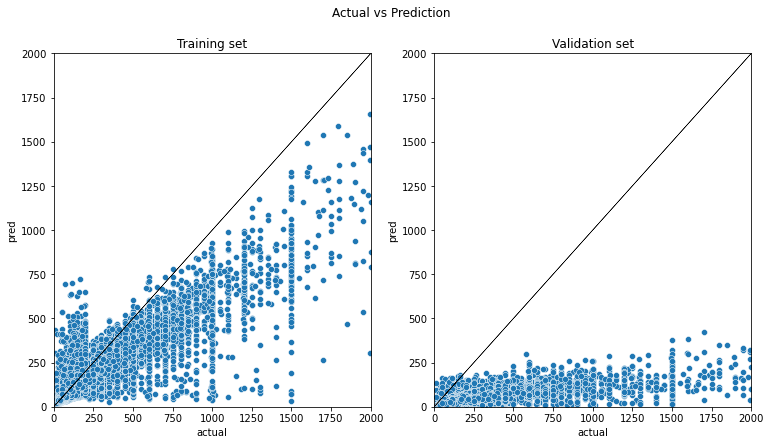

In [36]:
fig = plt.figure(figsize=(12.5, 6.5))
plt.suptitle('Actual vs Prediction')

plt.subplot(1, 2, 1)
ax = sns.scatterplot(pred_train['actual'], pred_train['pred'])
plt.plot(pred_train['actual'], pred_train['actual'], color='black', linewidth=0.5)
ax.set_xlim(0, 2000)
ax.set_ylim(0, 2000)
ax.set_title('Training set');
# plt.axes().set_aspect('equal')
plt.subplot(1, 2, 2)
ax = sns.scatterplot(pred_valid['actual'], pred_valid['pred'])
plt.plot(pred_valid['actual'], pred_valid['actual'], color='black', linewidth=0.5)
ax.set_xlim(0, 2000)
ax.set_ylim(0, 2000)
plt.title('Validation set');

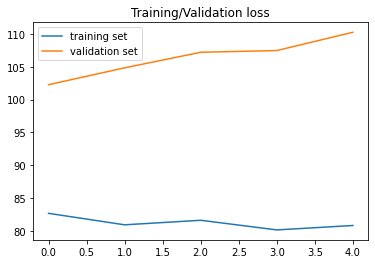

In [37]:
plt.plot(metrics['train_losses'], label='training set')
plt.plot(metrics['valid_losses'], label='validation set')
plt.title('Training/Validation loss')
plt.legend();

# Submission

In [38]:
pred_test_dfs = [pd.read_csv(os.path.join(output_dir, f'cv_fold{i + 1}_test.csv')) for i in range(N_SPLITS)]

In [39]:
pred_test = pd.concat(pred_test_dfs).groupby('id').sum()
pred_test = pred_test / N_SPLITS

In [40]:
pred_test.to_csv(os.path.join(output_dir, f'{EXPERIMENT}_submission.csv'), header=None)

# Visualization

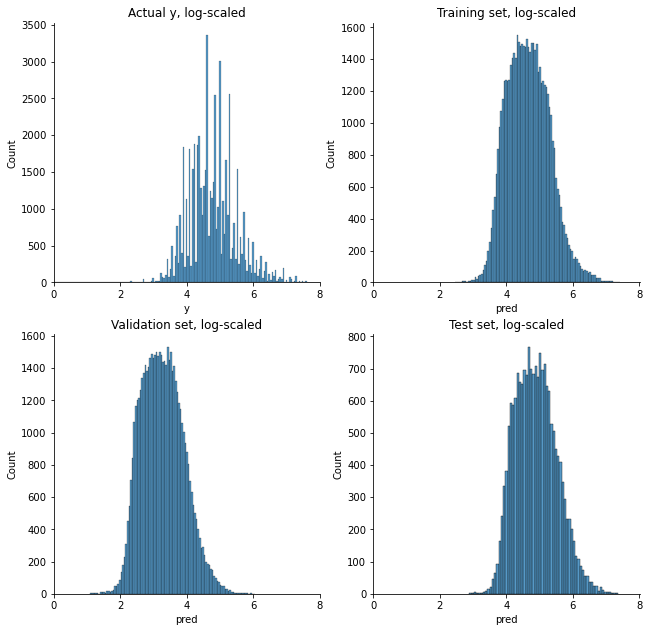

In [41]:
ylim_min, ylim_max = np.log(y_min * CLIP_LOWER_RATE), np.log(y_max * CLIP_UPPER_RATE)
fig = plt.figure(figsize=(10.5, 10.5))
plt.subplot(2, 2, 1)
ax = sns.histplot(y_log)
ax.set_title('Actual y, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

plt.subplot(2, 2, 2)
ax = sns.histplot(np.log(pred_train['pred']))
ax.set_title('Training set, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

plt.subplot(2, 2, 3)
ax = sns.histplot(np.log(pred_valid['pred']))
ax.set_title('Validation set, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

plt.subplot(2, 2, 4)
ax = sns.histplot(np.log(pred_test['pred']))
ax.set_title('Test set, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

fig.savefig(os.path.join(output_dir, 'figure.png'))

In [42]:
logger.debug('Complete({:.3f} seconds passed)'.format(time.time() - SINCE))

# Feature importance

In [43]:
pd.options.display.float_format = '{:.5f}'.format

In [44]:
models = []
for i, (train_idx, vaild_idx) in enumerate(splitter.split(X=X, y=y_labels)):
    num_fold = i + 1

    ## モデルの保存
    filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.pkl')
    with open(filepath_fold_model, 'rb') as f:
        model = pickle.load(f)
    models.append(model)

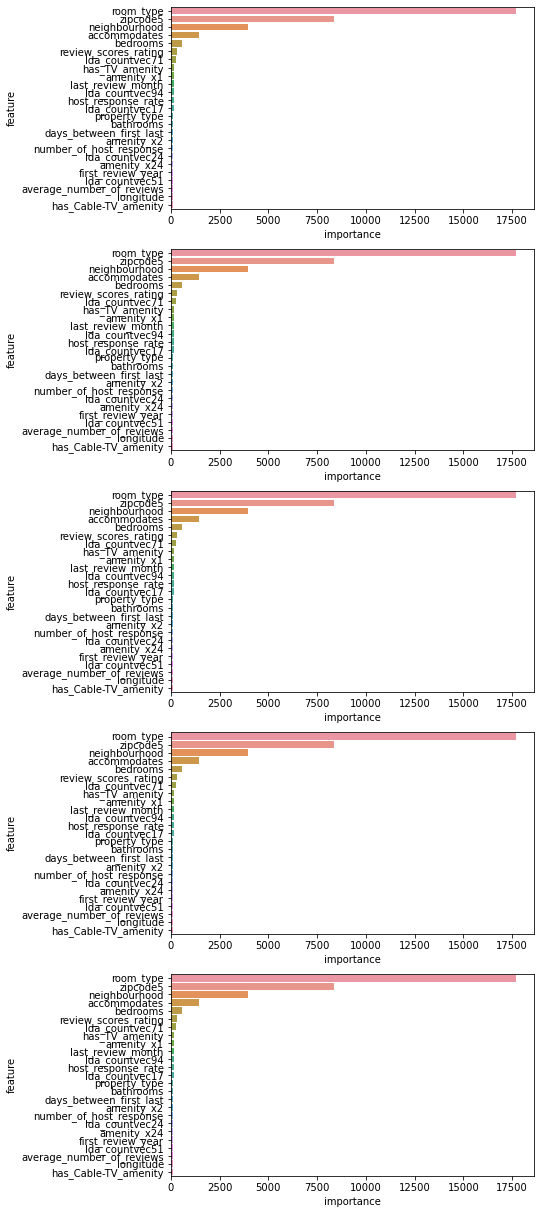

In [45]:
fig = plt.figure(figsize=(6.5, 21.5))
for i in range(N_SPLITS):
    plt.subplot(5, 1, i + 1)
    imp_df = pd.DataFrame(data=model['class0'].feature_importances_, columns=['importance'])
    imp_df['feature'] = X_train.columns.tolist()
    imp_df.sort_values(['importance', 'feature'], ascending=False, inplace=True)
    sns.barplot(data=imp_df.head(25), y='feature', x='importance')
fig.savefig(os.path.join(output_dir, 'feature_importance0.png'))

AttributeError: 'StackingRegressor' object has no attribute 'feature_importances_'

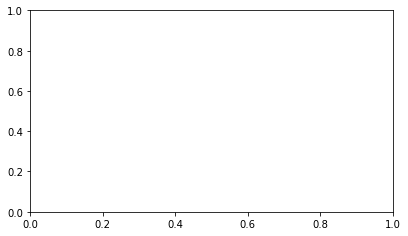

In [46]:
fig = plt.figure(figsize=(6.5, 21.5))
for i in range(N_SPLITS):
    plt.subplot(5, 1, i + 1)
    imp_df = pd.DataFrame(data=model['class1'].feature_importances_, columns=['importance'])
    imp_df['feature'] = X_train.columns.tolist()
    imp_df.sort_values(['importance', 'feature'], ascending=False, inplace=True)
    sns.barplot(data=imp_df.head(25), y='feature', x='importance')
fig.savefig(os.path.join(output_dir, 'feature_importance0.png'))

# Error

In [47]:
pred_valid = pd.read_csv(os.path.join(output_dir, 'prediction_valid.csv'))

In [48]:
pred_valid['diff'] = pred_valid['pred'] - pred_valid['actual']

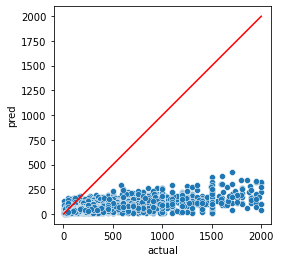

In [49]:
fig = plt.figure()
plt.axes().set_aspect('equal')
ax = sns.scatterplot(data=pred_valid, x='actual', y='pred')
ax = sns.lineplot(data=pred_valid, x='actual', y='actual', color='red')
fig.savefig(os.path.join(output_dir, 'compare_actual_prediction.png'))

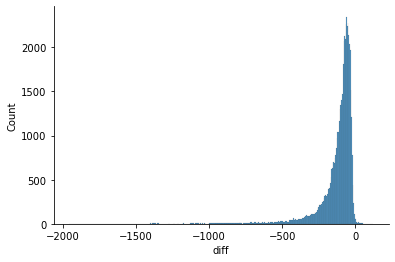

In [50]:
pred_valid.describe()
sns.histplot(data=pred_valid, x='diff')
sns.despine()

In [51]:
diff_df = pd.merge(X, pred_valid[['id', 'diff']]).set_index('id')

In [52]:
%%time
import sweetviz
report = sweetviz.analyze(diff_df, target_feat='diff', pairwise_analysis='off')
report.show_html(os.path.join(output_dir, ('sweetviz_error_report.html')))

                                             |                                             | [  0%]   00:00 ->…

Report C:\Users\nndropout\aiquest2021-assesment\experiments\05-10\sweetviz_error_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
Wall time: 3min 9s


In [53]:
pd.options.display.max_rows = 50
pd.options.display.max_columns = diff_df.shape[1]

In [54]:
diff_df.sort_values('diff').head(50)

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,has_Coffee-maker_amenity,has__amenity,has_Beach-essentials_amenity,has_Ethernet-connection_amenity,has_Extra-pillows-and-blankets_amenity,has_Wide-entryway_amenity,has_Laptop-friendly-workspace_amenity,has_Pets-live-on-this-property_amenity,has_Lake-access_amenity,has_Crib_amenity,has_TV_amenity,has_Smoking-allowed_amenity,has_Waterfront_amenity,has_Other_amenity,has_Changing-table_amenity,has_Ground-floor-access_amenity,has_Oven_amenity,has_Baby-bath_amenity,has_Carbon-monoxide-detector_amenity,has_Paid-parking-off-premises_amenity,has_Bathtub_amenity,has_Heating_amenity,has_Pocket-wifi_amenity,has_Ski-inSki-out_amenity,has_Handheld-shower-head_amenity,has_Kitchen_amenity,has_Self-Check-In_amenity,has_24-hour-check-in_amenity,has_Long-term-stays-allowed_amenity,has_Free-parking-on-premises_amenity,has_Garden-or-backyard_amenity,has_Beachfront_amenity,has_translation-missing-en.hosting_amenity_49_amenity,has_Wide-clearance-to-shower-&-toilet_amenity,has_Firm-mattress_amenity,has_Dishwasher_amenity,has_translation-missing-en.hosting_amenity_50_amenity,has_High-chair_amenity,has_Cat(s)_amenity,has_EV-charger_amenity,has_Fireplace-guards_amenity,has_Essentials_amenity,has_BBQ-grill_amenity,has_Smartlock_amenity,has_Single-level-home_amenity,has_Buzzerwireless-intercom_amenity,has_Gym_amenity,has_Room-darkening-shades_amenity,has_Wireless-Internet_amenity,has_Suitable-for-events_amenity,has_Doorman-Entry_amenity,has_Lock-on-bedroom-door_amenity,has_Smoke-detector_amenity,has_Shampoo_amenity,has_Elevator-in-building_amenity,has_Table-corner-guards_amenity,has_Lockbox_amenity,has_Luggage-dropoff-allowed_amenity,has_Safety-card_amenity,has_Wide-hallway-clearance_amenity,has_Accessible-height-bed_amenity,has_Firm-matress_amenity,has_Microwave_amenity,has_Smart-lock_amenity,has_Doorman_amenity,has_Outlet-covers_amenity,has_Other-pet(s)_amenity,has_Familykid-friendly_amenity,has_Flat_amenity,has_Step-free-access_amenity,has_Cooking-basics_amenity,has_Washer_amenity,has_Hot-water_amenity,has_Air-purifier_amenity,has_Grab-rails-for-shower-and-toilet_amenity,has_First-aid-kit_amenity,has_Air-conditioning_amenity,has_Dryer_amenity,has_Disabled-parking-spot_amenity,has_Wheelchair-accessible_amenity,has_Keypad_amenity,has_Babysitter-recommendations_amenity,has_Host-greets-you_amenity,has_Hair-dryer_amenity,has_-smooth-pathway-to-front-door_amenity,has_Window-guards_amenity,has_Flat-smooth-pathway-to-front-door_amenity,has_Patio-or-balcony_amenity,has_Accessible-height-toilet_amenity,has_Dog(s)_amenity,has_Washer--Dryer_amenity,has_Wide-doorway_amenity,has_Wide-clearance-to-bed_amenity,has_Path-to-entrance-lit-at-night_amenity,has_Elevator_amenity,has_Cable-TV_amenity,has_Pack-’n-Playtravel-crib_amenity,has_Private-entrance_amenity,has_Refrigerator_amenity,has_Stair-gates_amenity,has_Indoor-fireplace_amenity,has_Bathtub-with-shower-chair_amenity,has_Internet_amenity,has_Iron_amenity,has_Breakfast_amenity,has_Children’s-dinnerware_amenity,has_Baby-monitor_amenity,has_Dishes-and-silverware_amenity,has_Fixed-grab-bars-for-shower-&-toilet_amenity,has_Private-living-room_amenity,has_Stove_amenity,has_Well-lit-path-to-entrance_amenity,has_Hot-tub_amenity,has_Hangers_amenity,has_Pool_amenity,has_Pets-allowed_amenity,has_Private-bathroom_amenity,has_Free-parking-on-street_amenity,has_Children’s-books-and-toys_amenity,has_Hot-water-kettle_amenity,has_Fire-extinguisher_amenity,has_Bed-linens_amenity,has_Game-console_amenity,has_Cleaning-before-checkout_amenity,days_between_first_last,average_number_of_reviews,number_of_host_response,average_number_of_host_response,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_rev

In [55]:
diff_df.sort_values('diff').tail(50)

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,has_Coffee-maker_amenity,has__amenity,has_Beach-essentials_amenity,has_Ethernet-connection_amenity,has_Extra-pillows-and-blankets_amenity,has_Wide-entryway_amenity,has_Laptop-friendly-workspace_amenity,has_Pets-live-on-this-property_amenity,has_Lake-access_amenity,has_Crib_amenity,has_TV_amenity,has_Smoking-allowed_amenity,has_Waterfront_amenity,has_Other_amenity,has_Changing-table_amenity,has_Ground-floor-access_amenity,has_Oven_amenity,has_Baby-bath_amenity,has_Carbon-monoxide-detector_amenity,has_Paid-parking-off-premises_amenity,has_Bathtub_amenity,has_Heating_amenity,has_Pocket-wifi_amenity,has_Ski-inSki-out_amenity,has_Handheld-shower-head_amenity,has_Kitchen_amenity,has_Self-Check-In_amenity,has_24-hour-check-in_amenity,has_Long-term-stays-allowed_amenity,has_Free-parking-on-premises_amenity,has_Garden-or-backyard_amenity,has_Beachfront_amenity,has_translation-missing-en.hosting_amenity_49_amenity,has_Wide-clearance-to-shower-&-toilet_amenity,has_Firm-mattress_amenity,has_Dishwasher_amenity,has_translation-missing-en.hosting_amenity_50_amenity,has_High-chair_amenity,has_Cat(s)_amenity,has_EV-charger_amenity,has_Fireplace-guards_amenity,has_Essentials_amenity,has_BBQ-grill_amenity,has_Smartlock_amenity,has_Single-level-home_amenity,has_Buzzerwireless-intercom_amenity,has_Gym_amenity,has_Room-darkening-shades_amenity,has_Wireless-Internet_amenity,has_Suitable-for-events_amenity,has_Doorman-Entry_amenity,has_Lock-on-bedroom-door_amenity,has_Smoke-detector_amenity,has_Shampoo_amenity,has_Elevator-in-building_amenity,has_Table-corner-guards_amenity,has_Lockbox_amenity,has_Luggage-dropoff-allowed_amenity,has_Safety-card_amenity,has_Wide-hallway-clearance_amenity,has_Accessible-height-bed_amenity,has_Firm-matress_amenity,has_Microwave_amenity,has_Smart-lock_amenity,has_Doorman_amenity,has_Outlet-covers_amenity,has_Other-pet(s)_amenity,has_Familykid-friendly_amenity,has_Flat_amenity,has_Step-free-access_amenity,has_Cooking-basics_amenity,has_Washer_amenity,has_Hot-water_amenity,has_Air-purifier_amenity,has_Grab-rails-for-shower-and-toilet_amenity,has_First-aid-kit_amenity,has_Air-conditioning_amenity,has_Dryer_amenity,has_Disabled-parking-spot_amenity,has_Wheelchair-accessible_amenity,has_Keypad_amenity,has_Babysitter-recommendations_amenity,has_Host-greets-you_amenity,has_Hair-dryer_amenity,has_-smooth-pathway-to-front-door_amenity,has_Window-guards_amenity,has_Flat-smooth-pathway-to-front-door_amenity,has_Patio-or-balcony_amenity,has_Accessible-height-toilet_amenity,has_Dog(s)_amenity,has_Washer--Dryer_amenity,has_Wide-doorway_amenity,has_Wide-clearance-to-bed_amenity,has_Path-to-entrance-lit-at-night_amenity,has_Elevator_amenity,has_Cable-TV_amenity,has_Pack-’n-Playtravel-crib_amenity,has_Private-entrance_amenity,has_Refrigerator_amenity,has_Stair-gates_amenity,has_Indoor-fireplace_amenity,has_Bathtub-with-shower-chair_amenity,has_Internet_amenity,has_Iron_amenity,has_Breakfast_amenity,has_Children’s-dinnerware_amenity,has_Baby-monitor_amenity,has_Dishes-and-silverware_amenity,has_Fixed-grab-bars-for-shower-&-toilet_amenity,has_Private-living-room_amenity,has_Stove_amenity,has_Well-lit-path-to-entrance_amenity,has_Hot-tub_amenity,has_Hangers_amenity,has_Pool_amenity,has_Pets-allowed_amenity,has_Private-bathroom_amenity,has_Free-parking-on-street_amenity,has_Children’s-books-and-toys_amenity,has_Hot-water-kettle_amenity,has_Fire-extinguisher_amenity,has_Bed-linens_amenity,has_Game-console_amenity,has_Cleaning-before-checkout_amenity,days_between_first_last,average_number_of_reviews,number_of_host_response,average_number_of_host_response,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_rev

In [56]:
diff_df.corr()

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,has_Coffee-maker_amenity,has__amenity,has_Beach-essentials_amenity,has_Ethernet-connection_amenity,has_Extra-pillows-and-blankets_amenity,has_Wide-entryway_amenity,has_Laptop-friendly-workspace_amenity,has_Pets-live-on-this-property_amenity,has_Lake-access_amenity,has_Crib_amenity,has_TV_amenity,has_Smoking-allowed_amenity,has_Waterfront_amenity,has_Other_amenity,has_Changing-table_amenity,has_Ground-floor-access_amenity,has_Oven_amenity,has_Baby-bath_amenity,has_Carbon-monoxide-detector_amenity,has_Paid-parking-off-premises_amenity,has_Bathtub_amenity,has_Heating_amenity,has_Pocket-wifi_amenity,has_Ski-inSki-out_amenity,has_Handheld-shower-head_amenity,has_Kitchen_amenity,has_Self-Check-In_amenity,has_24-hour-check-in_amenity,has_Long-term-stays-allowed_amenity,has_Free-parking-on-premises_amenity,has_Garden-or-backyard_amenity,has_Beachfront_amenity,has_translation-missing-en.hosting_amenity_49_amenity,has_Wide-clearance-to-shower-&-toilet_amenity,has_Firm-mattress_amenity,has_Dishwasher_amenity,has_translation-missing-en.hosting_amenity_50_amenity,has_High-chair_amenity,has_Cat(s)_amenity,has_EV-charger_amenity,has_Fireplace-guards_amenity,has_Essentials_amenity,has_BBQ-grill_amenity,has_Smartlock_amenity,has_Single-level-home_amenity,has_Buzzerwireless-intercom_amenity,has_Gym_amenity,has_Room-darkening-shades_amenity,has_Wireless-Internet_amenity,has_Suitable-for-events_amenity,has_Doorman-Entry_amenity,has_Lock-on-bedroom-door_amenity,has_Smoke-detector_amenity,has_Shampoo_amenity,has_Elevator-in-building_amenity,has_Table-corner-guards_amenity,has_Lockbox_amenity,has_Luggage-dropoff-allowed_amenity,has_Safety-card_amenity,has_Wide-hallway-clearance_amenity,has_Accessible-height-bed_amenity,has_Firm-matress_amenity,has_Microwave_amenity,has_Smart-lock_amenity,has_Doorman_amenity,has_Outlet-covers_amenity,has_Other-pet(s)_amenity,has_Familykid-friendly_amenity,has_Flat_amenity,has_Step-free-access_amenity,has_Cooking-basics_amenity,has_Washer_amenity,has_Hot-water_amenity,has_Air-purifier_amenity,has_Grab-rails-for-shower-and-toilet_amenity,has_First-aid-kit_amenity,has_Air-conditioning_amenity,has_Dryer_amenity,has_Disabled-parking-spot_amenity,has_Wheelchair-accessible_amenity,has_Keypad_amenity,has_Babysitter-recommendations_amenity,has_Host-greets-you_amenity,has_Hair-dryer_amenity,has_-smooth-pathway-to-front-door_amenity,has_Window-guards_amenity,has_Flat-smooth-pathway-to-front-door_amenity,has_Patio-or-balcony_amenity,has_Accessible-height-toilet_amenity,has_Dog(s)_amenity,has_Washer--Dryer_amenity,has_Wide-doorway_amenity,has_Wide-clearance-to-bed_amenity,has_Path-to-entrance-lit-at-night_amenity,has_Elevator_amenity,has_Cable-TV_amenity,has_Pack-’n-Playtravel-crib_amenity,has_Private-entrance_amenity,has_Refrigerator_amenity,has_Stair-gates_amenity,has_Indoor-fireplace_amenity,has_Bathtub-with-shower-chair_amenity,has_Internet_amenity,has_Iron_amenity,has_Breakfast_amenity,has_Children’s-dinnerware_amenity,has_Baby-monitor_amenity,has_Dishes-and-silverware_amenity,has_Fixed-grab-bars-for-shower-&-toilet_amenity,has_Private-living-room_amenity,has_Stove_amenity,has_Well-lit-path-to-entrance_amenity,has_Hot-tub_amenity,has_Hangers_amenity,has_Pool_amenity,has_Pets-allowed_amenity,has_Private-bathroom_amenity,has_Free-parking-on-street_amenity,has_Children’s-books-and-toys_amenity,has_Hot-water-kettle_amenity,has_Fire-extinguisher_amenity,has_Bed-linens_amenity,has_Game-console_amenity,has_Cleaning-before-checkout_amenity,days_between_first_last,average_number_of_reviews,number_of_host_response,average_number_of_host_response,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_rev

In [57]:
diff_df.corr().sort_values('diff')['diff'].head(50)

accommodates                           -0.47372
bedrooms                               -0.45172
bathrooms                              -0.41608
beds                                   -0.39443
room_type                              -0.26163
lda_countvec17                         -0.24294
has_Familykid-friendly_amenity         -0.18935
has_Indoor-fireplace_amenity           -0.16616
has_TV_amenity                         -0.15898
has_Cable-TV_amenity                   -0.15460
has_Dryer_amenity                      -0.13971
amenity_x1                             -0.13842
lda_countvec92                         -0.13685
has_Washer_amenity                     -0.13665
has_Suitable-for-events_amenity        -0.13383
lda_countvec47                         -0.12412
amenity_x3                             -0.11251
has_thumbnail                          -0.10926
lda_countvec71                         -0.09882
lda_countvec53                         -0.09626
lda_countvec6                          -

In [58]:
from lightgbm import LGBMRegressor
estimator = LGBMRegressor(random_state=SEED, n_jobs=-1, importance_type='gain').fit(diff_df.drop(columns=['diff']), diff_df['diff'])

In [59]:
imp_df = pd.DataFrame(data=estimator.feature_importances_, columns=['importance'])

In [60]:
imp_df['feature'] = estimator.feature_name_

In [61]:
imp_df.sort_values(['importance', 'feature'], ascending=False, inplace=True)
imp_df

,importance,feature
3,993745992.70312,bedrooms
1,531819461.90625,bathrooms
0,493137910.29688,accommodates
18,268152291.10156,room_type
13,251916461.10156,longitude
...,...,...
92,0.00000,has_Air-purifier_amenity
95,0.00000,has_Air-conditioning_amenity
107,0.00000,has_Accessible-height-toilet_amenity
79,0.00000,has_Accessible-height-bed_amenity


In [62]:
imp_df.to_csv(os.path.join(output_dir, 'diff_feature_importances.csv'), index=False)